# CA684 Machine Learning Assignment Spring 2024


In [1]:
# Standard libraries for data handling and manipulation
import numpy as np
import pandas as pd
import os
import io

# Machine Learning and Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, LSTM, Dense, Dropout, Embedding, Flatten,
                                     Conv1D, MaxPooling1D, GlobalAveragePooling2D)
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing import image

# Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords

# Model tuning and optimization
from kerastuner.tuners import RandomSearch, BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters

# Data splitting utility
from sklearn.model_selection import train_test_split

# Metrics to evaluate model performance
from sklearn import metrics

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

# Configuration and warnings
import warnings
warnings.filterwarnings('ignore')  # To suppress warnings when necessary

# Matplotlib font configuration for better plot readability
plt.rc('font', family='DejaVu Sans', weight='bold', size=16)


In [3]:
# set random seed
np.random.seed(seed=42)

## Dataset

The train and test datasets are shared in **parquet** format.

In order to download the dataset, please sign the NDA first.

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import os

# Path to the directory with your parquet files
train_dir = '/content/drive/MyDrive/2024/train'
test_dir = '/content/drive/MyDrive/2024/test'

# List all files in the train directory
parquet_filenames_train = [f for f in os.listdir(train_dir) if f.endswith('.parquet')]
parquet_filenames_test = [f for f in os.listdir(test_dir) if f.endswith('.parquet')]

# Now you can check the length of the file list
print(f"Number of files in train: {len(parquet_filenames_train)}")
print(f"Number of files in test: {len(parquet_filenames_test)}")


Number of files in train: 362
Number of files in test: 362


In [6]:
PATH = '/content/drive/MyDrive/2024'

In [7]:
def read_data(folder, filenames):
    """ Read parquet data from mutiple files """

    dataframes = [
        pd.read_parquet(f"{PATH}/{folder}/{filename}")
        for filename in filenames
    ]

    return pd.concat(dataframes)

In [8]:
df_train = read_data("train", parquet_filenames_train)
f"Number of rows in train: {len(df_train):,}"

'Number of rows in train: 229,624'

In [ ]:
f"Number of unique products in train: {len(df_train['product_id'].unique()):,}"

'Number of unique products in train: 229,624'

In [ ]:
f"Number of columns in train: {len(df_train.columns):,}"

'Number of columns in train: 26'

In [ ]:
df_train.head()

product_id                                              title  \
0  1552102799  70s Swimwear Mens Swim Trunks, Vintage Swimwea...   
1  1625806056  Science Biology Print Swim Trunks, Mens Swimwe...   
2  1638948792  LA LEELA Men&#39;s Pareo Swim Trunk Holiday Sa...   
3  1427104792  Skull Swim Trunks Black & White Swim Shorts Go...   
4  1217293715                        Space Men&#39;s Swim Trunks   

                                         description  \
0  Vintage 70s men swim trunks, swim shorts  blue...   
1  These swim trunks have everything you need for...   
2  Welcome to LA LEELA \n\nEnjoy Beach, Breeze an...   
3  **THIS ITEM IS MADE IN CHINA, PLEASE ALLOW 2-3...   
4  my original bright colorful abstract acrylic p...   

                                                tags      type room  \
0  men swimwear,high waist,marine anchor,retro sw...  physical        
1  swim briefs men,bathing suit,bathing shorts,ad...  physical        
2  Loungewear,Pareo for Him,bath towel,Resort Poo...  physical        
3  mens swim trunks,mens swim shorts,mens bathing...  physical        
4  abstract shorts,painted shorts,abstract art sh...  physical        

  craft_type recipient material occasion  ...  \
0                                         ...   
1                                         ...   
2                                         ...   
3                                         ...   
4                                         ...   

              bottom_category_text top_category_id top_category_text  \
0  clothing.mens_clothing.swimwear               5          clothing   
1  clothing.mens_clothing.swimwear               5          clothing   
2  clothing.mens_clothing.swimwear               5          clothing   
3  clothing.mens_clothing.swimwear               5          clothing   
4  clothing.mens_clothing.swimwear               5          clothing   

  primary_color_id primary_color_text  secondary_color_id  \
0                2               blue                  14   
1                2               blue                   9   
2               12             purple                   9   
3                1              black                  17   
4               13            rainbow                   9   

  secondary_color_text                                      image/encoded  \
0                  red  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
1                green  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
2                green  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
3                white  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
4                green  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   

  image/width  image/height  
0         570           427  
1         570           570  
2         570           570  
3         570           570  
4         570           570  

[5 rows x 26 columns]

In [ ]:
df_train.iloc[0]

product_id                                                      559421921
title                   Happy Fall Y&#39;all Candy Wrapper, Fall Hersh...
description             Happy Fall Y&#39;all...Here&#39;s a cute Autum...
tags                    Fall Candy Wrapper,Fall Hershey Wrapper,Fall P...
type                                                             download
room                                                                     
craft_type                                                               
recipient                                                                
material                                                                 
occasion                                                                 
holiday                                                      thanksgiving
art_subject                                                              
style                                                                    
shape                                 

In [ ]:
df_train.iloc[1]

product_id                                                      221375267
title                   Great Gatsby Art Deco Candy Bar Wrapper, Black...
description             This listing is for a PRINTABLE candy bar wrap...
tags                    birthday,bithday party,art deco,great gatsby,H...
type                                                             download
room                                                                     
craft_type                                                               
recipient                                                           adult
material                                                                 
occasion                                                         birthday
holiday                                                                  
art_subject                                                              
style                                                            art deco
shape                                 

In [ ]:
def show_images(dataframe, N=100):

    num_cols = 5
    num_rows = N // num_cols
    plt_height = 3 * num_rows

    plt.figure(figsize=(12, plt_height))
    for i, row in dataframe[:N].iterrows():
        # axis
        ax = plt.subplot(num_rows, num_cols, i + 1)
        # data
        img_bytes = row["image/encoded"]
        label = row["top_category_text"] if "top_category_text" in row else "unknown"
        # image
        bytes_io = io.BytesIO(img_bytes)
        image = Image.open(bytes_io)
        # plot
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)
        plt.xlabel(label, fontsize = 12)
    plt.show()

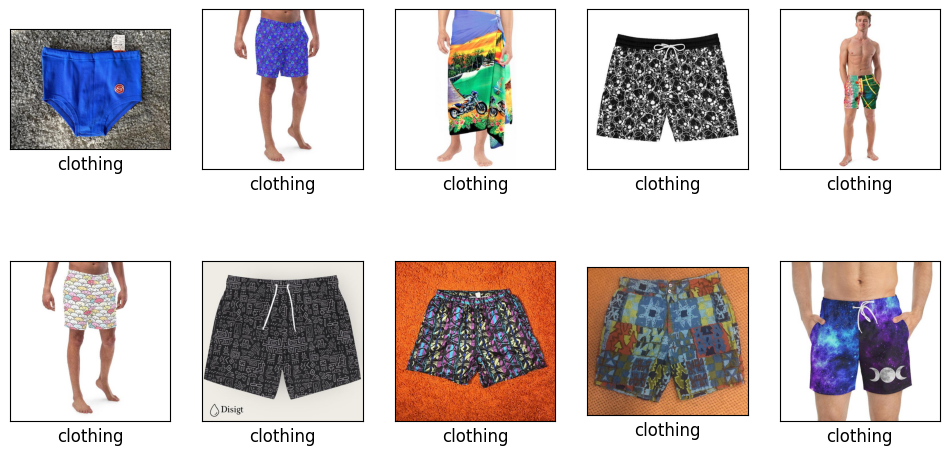

In [ ]:
show_images(df_train, 10)

## Exploratory Data Analysis

It is important to familiarize yourself with the dataset by using measures of centrality (e.g. mean) and statistical dispersion (e.g. variance) and data visualization methods. The following is just some Pandas preprocessing and Matplotlib visualizations to get you started. Feel free to explore the data much further and come up with ideas that might help you in the task!

### Training Dataset

This dataset can be used to train models and learn patterns from.

In [ ]:
df_train.shape

(229624, 26)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229624 entries, 0 to 184
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   product_id            229624 non-null  int64 
 1   title                 229624 non-null  object
 2   description           229624 non-null  object
 3   tags                  229624 non-null  object
 4   type                  229624 non-null  object
 5   room                  229624 non-null  object
 6   craft_type            229624 non-null  object
 7   recipient             229624 non-null  object
 8   material              229624 non-null  object
 9   occasion              229624 non-null  object
 10  holiday               229624 non-null  object
 11  art_subject           229624 non-null  object
 12  style                 229624 non-null  object
 13  shape                 229624 non-null  object
 14  pattern               229624 non-null  object
 15  bottom_category_id    229

In [ ]:
#Check for missing values
df_train.isna().sum()

product_id              0
title                   0
description             0
tags                    0
type                    0
room                    0
craft_type              0
recipient               0
material                0
occasion                0
holiday                 0
art_subject             0
style                   0
shape                   0
pattern                 0
bottom_category_id      0
bottom_category_text    0
top_category_id         0
top_category_text       0
primary_color_id        0
primary_color_text      0
secondary_color_id      0
secondary_color_text    0
image/encoded           0
image/width             0
image/height            0
dtype: int64

In [ ]:
df_train.head(2)

product_id                                              title  \
0  1552102799  70s Swimwear Mens Swim Trunks, Vintage Swimwea...   
1  1625806056  Science Biology Print Swim Trunks, Mens Swimwe...   

                                         description  \
0  Vintage 70s men swim trunks, swim shorts  blue...   
1  These swim trunks have everything you need for...   

                                                tags      type room  \
0  men swimwear,high waist,marine anchor,retro sw...  physical        
1  swim briefs men,bathing suit,bathing shorts,ad...  physical        

  craft_type recipient material occasion  ...  \
0                                         ...   
1                                         ...   

              bottom_category_text top_category_id top_category_text  \
0  clothing.mens_clothing.swimwear               5          clothing   
1  clothing.mens_clothing.swimwear               5          clothing   

  primary_color_id primary_color_text  secondary_color_id  \
0                2               blue                  14   
1                2               blue                   9   

  secondary_color_text                                      image/encoded  \
0                  red  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
1                green  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   

  image/width  image/height  
0         570           427  
1         570           570  

[2 rows x 26 columns]

In [ ]:
# Check for empty values/blanks
categorical_columns = ['title', 'description', 'tags', 'type', 'room', 'craft_type', 'recipient',
                       'material', 'occasion', 'holiday', 'art_subject', 'style', 'shape',
                       'pattern', 'bottom_category_text','top_category_text','primary_color_text','secondary_color_text','image/encoded']

for col in categorical_columns:
  blank_entries = df_train[col].apply(lambda x: x.strip()).eq("")
  print(f"Number of blank entries in {col}: {blank_entries.sum()}")

Number of blank entries in title: 810
Number of blank entries in description: 810
Number of blank entries in tags: 31169
Number of blank entries in type: 348
Number of blank entries in room: 220686
Number of blank entries in craft_type: 201862
Number of blank entries in recipient: 218815
Number of blank entries in material: 209384
Number of blank entries in occasion: 171550
Number of blank entries in holiday: 183359
Number of blank entries in art_subject: 226885
Number of blank entries in style: 213730
Number of blank entries in shape: 227137
Number of blank entries in pattern: 218042
Number of blank entries in bottom_category_text: 0
Number of blank entries in top_category_text: 0
Number of blank entries in primary_color_text: 0
Number of blank entries in secondary_color_text: 0
Number of blank entries in image/encoded: 0


In [ ]:
# Display records with blank title
empty_title = df_train[df_train['title']== '']
empty_title

product_id title description tags      type         room craft_type  \
15   1658905519                         physical                           
102  1590458244                         physical                           
350  1321031277                         physical                           
398   647845876                         physical                           
80   1655456995                         physical                           
..          ...   ...         ...  ...       ...          ...        ...   
589  1363456003                         physical                           
595   948374368                         physical                           
617  1529326216                         physical                           
694  1046386284                         physical                           
818   622385462                         physical  living room              

    recipient material        occasion  ...  \
15                                      ...   
102                                     ...   
350                                     ...   
398                     back to school  ...   
80                            birthday  ...   
..        ...      ...             ...  ...   
589                                     ...   
595                                     ...   
617                                     ...   
694                                     ...   
818              glass                  ...   

                                  bottom_category_text top_category_id  \
15        weddings.clothing.dresses.bridesmaid_dresses              14   
102          home_and_living.home_decor.seasonal_decor               8   
350  clothing.girls_clothing.hoodies_and_sweatshirt...               5   
398  clothing.girls_clothing.hoodies_and_sweatshirt...               5   
80   paper_and_party_supplies.paper.stationery.note...              10   
..                                                 ...             ...   
589  clothing.girls_clothing.baby_girls_clothing.pants               5   
595  clothing.girls_clothing.baby_girls_clothing.pants               5   
617  clothing.girls_clothing.baby_girls_clothing.pants               5   
694        clothing.girls_clothing.baby_girls_clothing               5   
818                           home_and_living.lighting               8   

            top_category_text primary_color_id primary_color_text  \
15                   weddings                0              beige   
102           home_and_living               17              white   
350                  clothing               17              white   
398                  clothing                9              green   
80   paper_and_party_supplies                0              beige   
..                        ...              ...                ...   
589                  clothing                2               blue   
595                  clothing               12             purple   
617                  clothing                2               blue   
694                  clothing               19              other   
818           home_and_living                5              clear   

     secondary_color_id secondary_color_text  \
15                    4                brown   
102                  13              rainbow   
350                  11                 pink   
398                  11                 pink   
80                   17                white   
..                  ...                  ...   
589                   2                 blue   
595                  17                white   
617                   9                green   
694                  17                white   
818                  16               silver   

                                         image/encoded image/width  \
15   b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...         570   
102  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...         570   
350  b'\xff\xd8\xff\xe

In [ ]:
df_train['type'].unique()

array(['download', 'physical', ''], dtype=object)

In [ ]:
df_train['type'].value_counts(dropna=False)

type
physical    218568
download     10708
               348
Name: count, dtype: int64

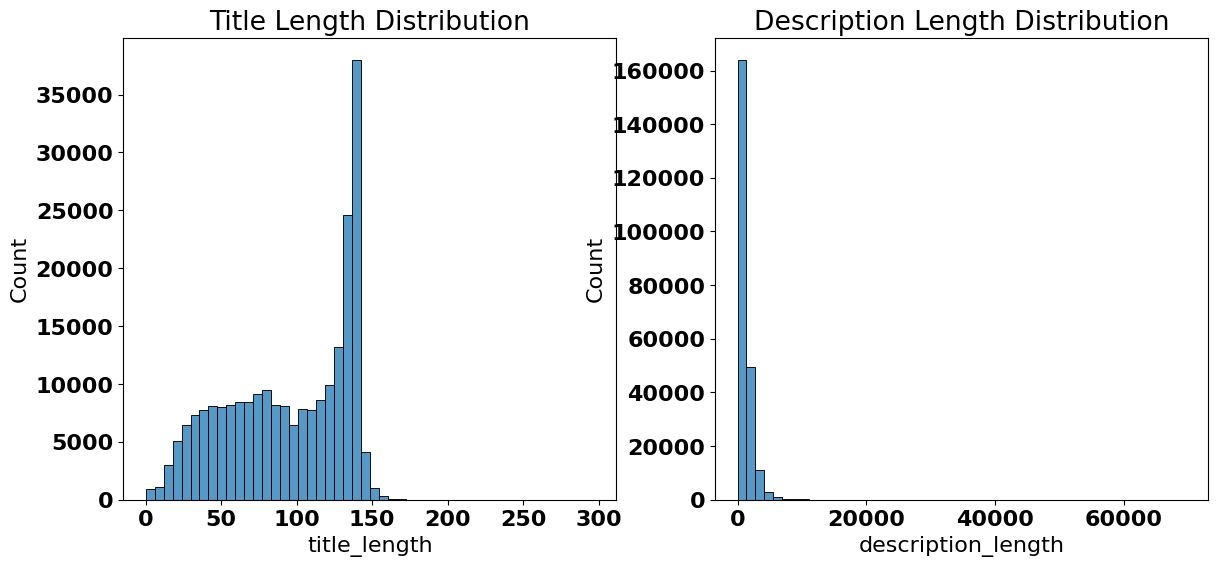

In [ ]:
# Text Length Distribution
df_train['title_length'] = df_train['title'].apply(len)
df_train['description_length'] = df_train['description'].apply(len)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_train['title_length'], bins=50)
plt.title('Title Length Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df_train['description_length'], bins=50)
plt.title('Description Length Distribution')
plt.show()


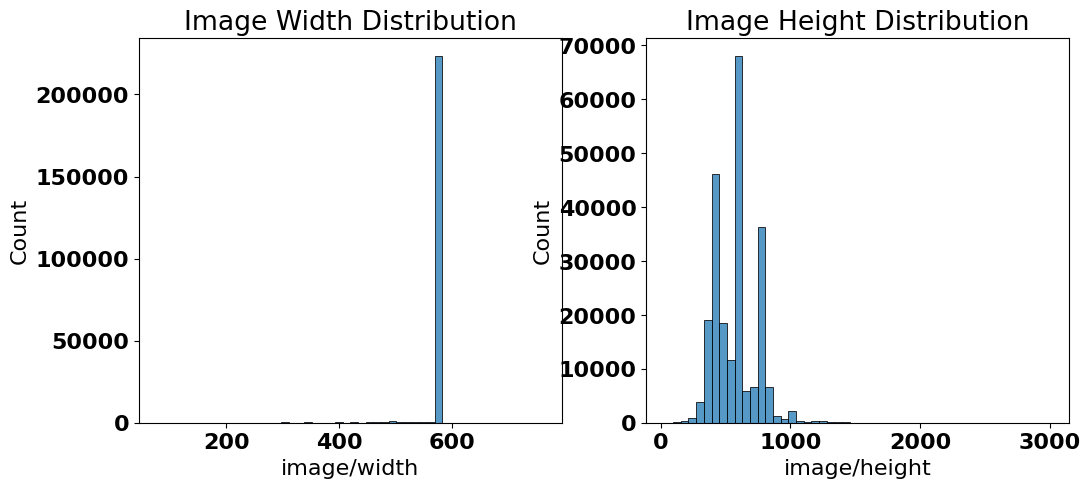

In [ ]:
# Image Size Analysis
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_train['image/width'], bins=50)
plt.title('Image Width Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df_train['image/height'], bins=50)
plt.title('Image Height Distribution')
plt.show()


In [ ]:
downloads = df_train[df_train['type']=='download']
downloads['top_category_text'].value_counts()

top_category_text
paper_and_party_supplies       4494
craft_supplies_and_tools       2472
weddings                        722
home_and_living                 652
electronics_and_accessories     560
books_movies_and_music          531
toys_and_games                  494
art_and_collectibles            409
bath_and_beauty                 179
pet_supplies                     81
accessories                      45
clothing                         38
bags_and_purses                  13
jewelry                          11
shoes                             7
Name: count, dtype: int64

In [ ]:
downloads = df_train[df_train['type']=='download']
downloads['bottom_category_text'].value_counts()

bottom_category_text
paper_and_party_supplies.paper.stationery.design_and_templates.templates.chore_chart_templates         96
paper_and_party_supplies.party_supplies.party_favors_and_games.party_games                             93
paper_and_party_supplies.paper.stationery.design_and_templates.templates.event_program_templates       92
paper_and_party_supplies.paper.stationery.design_and_templates.templates.personal_finance_templates    92
paper_and_party_supplies.paper.stationery.design_and_templates.graphic_design.store_graphics           92
                                                                                                       ..
accessories.hats_and_caps.fascinators_and_mini_hats.mini_hats                                           1
home_and_living.home_decor.decorative_storage.decorative_baskets                                        1
electronics_and_accessories.decals_and_skins.laptop.laptop_skins                                        1
clothing.boys_clothing.ba

In [ ]:
downloads = df_train[df_train['type']=='download']
downloads['primary_color_text'].value_counts()

primary_color_text
white        1873
black        1739
pink         1291
blue         1240
green         817
red           774
beige         643
brown         454
orange        327
purple        318
yellow        293
rainbow       261
other         259
gold          246
rose gold      62
clear          37
silver         35
bronze         26
copper         13
Name: count, dtype: int64

In [ ]:
downloads = df_train[df_train['type']=='download']
downloads['secondary_color_text'].value_counts()

secondary_color_text
white        2386
black        1615
green         935
pink          836
blue          814
red           615
gold          557
beige         480
brown         466
other         395
yellow        385
orange        352
purple        325
rainbow       250
silver        111
rose gold      61
clear          54
bronze         51
copper         20
Name: count, dtype: int64

In [ ]:
COLORS = df_train['primary_color_id'].unique()
NUM_COLORS = len(COLORS)
f"Number of primary colors in train: {NUM_COLORS:,}"

'Number of primary colors in train: 19'

In [ ]:
f"Number of top categories in train: {len(df_train['top_category_text'].unique()):,}"

'Number of top categories in train: 15'

In [ ]:
pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)

top_category_text
home_and_living                54600
craft_supplies_and_tools       33393
clothing                       30143
toys_and_games                 13835
accessories                    12416
paper_and_party_supplies       12207
bath_and_beauty                11327
weddings                       10143
shoes                           8892
art_and_collectibles            8716
jewelry                         7822
electronics_and_accessories     7474
bags_and_purses                 6650
books_movies_and_music          6262
pet_supplies                    5744
Name: count, dtype: int64

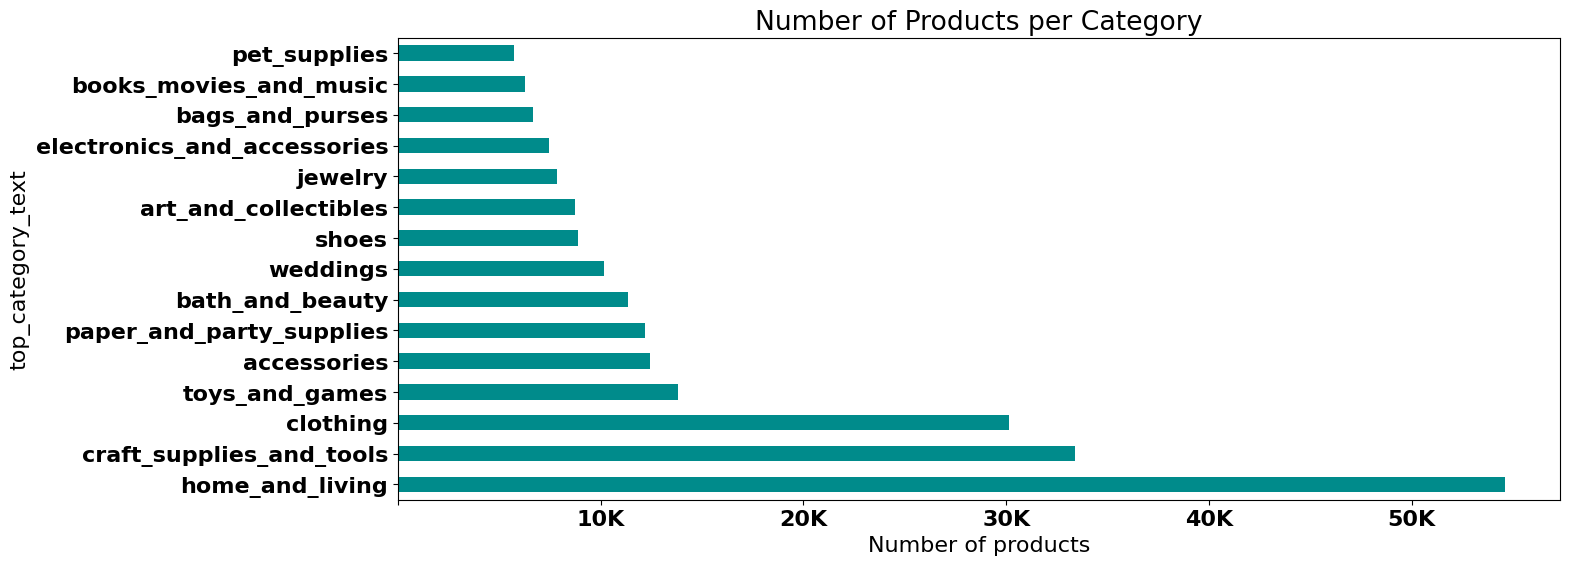

In [ ]:
figsize = (15, 6)
column = 'top_category_text'
x_limit = 60000
x_step = 10000
color = 'darkcyan'

figure, ax = plt.subplots(figsize=figsize)
pd.value_counts(
    df_train[column],
    sort=True, ascending=False).plot.barh(color=color)
plt.title(f"Number of Products per Category")
xlabels = [f'{x // 1000:,}K' for x in range(0, x_limit, x_step)]
plt.xticks(range(0, x_limit, x_step), xlabels)
plt.xlabel('Number of products')
plt.setp(ax.get_xticklabels()[0], visible=False)
plt.show()

In [ ]:
f"Number of bottom categories in train: {len(df_train['bottom_category_text'].unique()):,}"

'Number of bottom categories in train: 2,609'

## Model Training

Let's first split the data to be able to evaluate our model against a validation dataset. This validation set can also be used to fine tune your model before making the predictions on the hidden test set.

In [ ]:
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(
    df_train,
    test_size=0.1,
    stratify=df_train['bottom_category_text'],
    random_state=42)

In [ ]:
f"Number of products for training: {len(df_training):,}"

'Number of products for training: 206,661'

In [ ]:
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 22,963'

In [ ]:
df_training['bottom_category_text'].value_counts()

bottom_category_text
jewelry.earrings.dangle_earrings.chandbalis                                         88
accessories.scarves_and_wraps.scarves                                               88
home_and_living.kitchen_and_dining.dining_and_serving.cake_stands                   88
craft_supplies_and_tools.closures_and_fasteners.buttons                             88
art_and_collectibles.drawing_and_illustration.architectural_drawings                88
                                                                                    ..
weddings.clothing.jumpsuits_and_rompers                                             40
clothing.girls_clothing.baby_girls_clothing.socks_and_leg_warmers                   40
home_and_living.lighting.light_accessories                                          39
clothing.womens_clothing.pajamas_and_robes.sleep_masks_and_blindfolds.blindfolds    38
craft_supplies_and_tools.doll_and_model_supplies.noise_makers                       38
Name: count, Length: 2

In [ ]:
df_validation['bottom_category_text'].value_counts()

bottom_category_text
clothing.girls_clothing.underwear.panties                                                                             10
craft_supplies_and_tools.paints_inks_and_dyes.paint.chalk_paint                                                       10
clothing.girls_clothing.baby_girls_clothing.sweaters                                                                  10
craft_supplies_and_tools.storage_and_organization.containers.bottles_cans_and_jars.lids_rings_and_caps.bottle_caps    10
paper_and_party_supplies.party_supplies.party_decor.party_candles                                                     10
                                                                                                                      ..
home_and_living.furniture.entryway_furniture.standing_coat_racks                                                       4
jewelry.earrings.kaan_chains                                                                                           4
craft_suppl

In [ ]:
df_training['top_category_text'].value_counts()

top_category_text
home_and_living                49140
craft_supplies_and_tools       30056
clothing                       27139
toys_and_games                 12448
accessories                    11173
paper_and_party_supplies       10984
bath_and_beauty                10187
weddings                        9128
shoes                           8001
art_and_collectibles            7846
jewelry                         7040
electronics_and_accessories     6727
bags_and_purses                 5986
books_movies_and_music          5636
pet_supplies                    5170
Name: count, dtype: int64

In [ ]:
df_validation['top_category_text'].value_counts()

top_category_text
home_and_living                5460
craft_supplies_and_tools       3337
clothing                       3004
toys_and_games                 1387
accessories                    1243
paper_and_party_supplies       1223
bath_and_beauty                1140
weddings                       1015
shoes                           891
art_and_collectibles            870
jewelry                         782
electronics_and_accessories     747
bags_and_purses                 664
books_movies_and_music          626
pet_supplies                    574
Name: count, dtype: int64

In [ ]:
df_training['primary_color_text'].value_counts()

primary_color_text
black        27568
white        25727
blue         24866
brown        17908
pink         14458
red          14253
green        14011
beige        11142
silver        9670
gold          8609
other         8121
yellow        6445
purple        6101
orange        5056
clear         4113
rainbow       3945
bronze        2229
copper        1678
rose gold      761
Name: count, dtype: int64

In [ ]:
df_validation['primary_color_text'].value_counts()

primary_color_text
black        3105
white        2882
blue         2783
brown        1959
red          1582
pink         1571
green        1567
beige        1224
silver       1088
gold          960
other         864
yellow        786
purple        649
orange        569
rainbow       459
clear         433
bronze        242
copper        174
rose gold      66
Name: count, dtype: int64

In [ ]:
df_training['secondary_color_text'].value_counts()

secondary_color_text
white        33533
black        26817
blue         15777
brown        14462
green        14008
red          13773
gold         13597
silver       12189
pink         11495
beige         9314
yellow        8313
other         7985
orange        5527
rainbow       5467
purple        5149
clear         4042
bronze        2515
copper        1645
rose gold     1053
Name: count, dtype: int64

In [ ]:
df_validation['secondary_color_text'].value_counts()

secondary_color_text
white        3799
black        2953
blue         1770
brown        1682
green        1593
red          1477
gold         1464
pink         1349
silver       1324
beige        1006
yellow        913
other         830
rainbow       621
orange        608
purple        556
clear         441
bronze        282
copper        174
rose gold     121
Name: count, dtype: int64

### Training

As a simple example, let's follow the [Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) tutorial from scikit-learn that:

- processes the text using `CountVectorizer`, that builds a dictionary of features and transforms documents to feature vectors
- extracts term frequencies and inverse document frequencies using `TfidfTransformer`, (see [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
- trains a naïve Bayes classifier, which gives us a nice baseline

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(MultinomialNB())),
])

In [ ]:
train_text = df_training['title'].fillna('').values

In [ ]:
train_labels = df_training[['top_category_text','bottom_category_text','primary_color_text', 'secondary_color_text']].values

In [ ]:
text_clf.fit(train_text, train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(estimator=MultinomialNB()))])

### Evaluation

Using our validation dataset, compute a number of metrics to measure how well we generalize on our validation set.

In [ ]:
val_text = df_validation['title'].fillna('').values
val_labels = df_validation[['top_category_text','bottom_category_text','primary_color_text','secondary_color_text']].values

In [ ]:
index = 0
print(f"""
Product's title: {val_text[index][:80]}...
Prediction: '{text_clf.predict([val_text[index]])[0]}', Groundtruth: '{val_labels[index]}'
""".strip())

Product's title: Vintage enamel funnel - White metal funnel with handle - Large rusty funnel - Ki...
Prediction: '['home_and_living'
 'home_and_living.kitchen_and_dining.cookware.cooking_utensils_and_gadgets.funnels'
 'white' 'white']', Groundtruth: '['home_and_living'
 'home_and_living.kitchen_and_dining.cookware.cooking_utensils_and_gadgets.funnels'
 'white' 'blue']'


In [ ]:
df_validation.iloc[0]

product_id                                                     1085759015
title                   Vintage enamel funnel - White metal funnel wit...
description             Vintage enamel funnel - White metal funnel wit...
tags                    Enamel Funnel,Vintage metal funnel,Enamelware ...
type                                                             physical
room                                                                     
craft_type                                                     winemaking
recipient                                                                
material                                                                 
occasion                                                                 
holiday                                                                  
art_subject                                                              
style                                                                    
shape                                 

In [ ]:
val_text[:1]

array(['Vintage enamel funnel - White metal funnel with handle - Large rusty funnel - Kitchen pouring tool - Bulgarian enamelware - Old shabby chic'],
      dtype=object)

In [ ]:
predictions = text_clf.predict(val_text)

In [ ]:
from sklearn.metrics import f1_score

# F1 Score for each target
f1_scores = [f1_score(val_labels[:, i], predictions[:, i], average='weighted') for i in range(val_labels.shape[1])]

# Average F1 score for all targets
mean_f1_score = np.mean(f1_scores)

print("F1 scores for each target:", f1_scores)
print("Mean F1 score across all targets:", mean_f1_score)


F1 scores for each target: [0.6391911872463037, 0.5088365130760433, 0.2412019246025732, 0.14525450993068054]
Mean F1 score across all targets: 0.3836210337139002


In [ ]:
from sklearn.metrics import classification_report

for i, feature_name in enumerate(['top_category_text', 'bottom_category_text', 'primary_color_text', 'secondary_color_text']):
    print(f"Classification report for {feature_name}:")
    print(classification_report(val_labels[:, i], predictions[:, i], zero_division=0))


Classification report for top_category_text:
                             precision    recall  f1-score   support

                accessories       0.84      0.41      0.55      1243
       art_and_collectibles       0.86      0.09      0.16       870
            bags_and_purses       0.93      0.29      0.45       664
            bath_and_beauty       0.94      0.46      0.62      1140
     books_movies_and_music       0.98      0.31      0.47       626
                   clothing       0.73      0.96      0.83      3004
   craft_supplies_and_tools       0.62      0.77      0.69      3337
electronics_and_accessories       0.96      0.49      0.65       747
            home_and_living       0.54      0.96      0.69      5460
                    jewelry       0.91      0.37      0.53       782
   paper_and_party_supplies       0.80      0.58      0.67      1223
               pet_supplies       0.93      0.28      0.43       574
                      shoes       0.95      0.73      0.8

**Note** that this is just a baseline that uses a naïve Bayes classifier and uses the `title` only as inputs, there are many more parameters that can be used in addition to multiple architectures and processing approaches

# Data Preprocessing


## Data Cleaning -
* Remove blank records from title and description

In [ ]:
# Check for empty values/blanks
categorical_columns = ['title', 'description']

for col in categorical_columns:
  blank_entries = df_train[col].apply(lambda x: x.strip()).eq("")
  print(f"Number of blank entries in {col}: {blank_entries.sum()}")

Number of blank entries in title: 810
Number of blank entries in description: 810


In [9]:
# Drop rows where 'title' or 'description' is just whitespace or empty and save in a new dataframe
df = df_train[~(df_train['title'].str.strip() == '')]
df = df_train[~(df_train['description'].str.strip() == '')]
df.reset_index(drop=True, inplace=True)

In [ ]:
# check for blanks
categorical_columns = ['title', 'description']

for col in categorical_columns:
  blank_entries = df[col].apply(lambda x: x.strip()).eq("")
  print(f"Number of blank entries in {col}: {blank_entries.sum()}")

Number of blank entries in title: 0
Number of blank entries in description: 0


In [ ]:
#check shape
df.shape

(228814, 26)

## Text Preprocessing

In [ ]:
# Sample Text before processing
for i in range(0,5):
  print('Title: ' + df['title'].iloc[i])
  print('Description: ' + df['description'].iloc[i])
  print('Top Category: ' + df['top_category_text'].iloc[i])
  print('Bottom Category: ' + df['bottom_category_text'].iloc[i])
  print('Primary Color: ' + df['primary_color_text'].iloc[i])
  print('Secondary Color: ' + df['secondary_color_text'].iloc[i])
  print('==========================================================================================\n')

Title: 70s Swimwear Mens Swim Trunks, Vintage Swimwear, Swim Shorts, Beachwear, Retro Summer Clothes Holiday Collectible, Size S, Riga
Description: Vintage 70s men swim trunks, swim shorts  blue colour swimwear.\nAdjustable waist with ribbon..\n\n♥  Materials - capron\n♥  Size - Vintage size 44, probably new S size\n\n♥ Measured flat - \nWidth - 12&quot; (31cm)\nIt is excellent vintage condition. New\n\nReal colors may be little different from their appearance on your display.\nPleas look at the pictures carefully.\n\nI  will be happy to answer all of your questions.\n\nFeel free to visit my shop for other vintage goods:\nwww.etsy.com/shop/SkySecrets
Top Category: clothing
Bottom Category: clothing.mens_clothing.swimwear
Primary Color: blue
Secondary Color: red

Title: Science Biology Print Swim Trunks, Mens Swimwear, Microbes Swim Briefs Men, Men Shorts Activewear, Bathing Suit Surfing Short,Nerd Geek Gift
Description: These swim trunks have everything you need for a hot summer day—th

In [10]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove HTML entities
    text = re.sub(r'&\w+;', ' ', text)
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', ' ', text)
    # Remove punctuation
    text = re.sub(r'[' + string.punctuation + ']', ' ', text)
    # Remove new line character
    text = re.sub(r'\\n', ' ', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize tokens
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and not token.isdigit()]
    # Rejoin lemmatized tokens into a single string
    return ' '.join(lemmatized)

# Apply preprocessing to each row in your dataframe
df['cleaned_title'] = df['title'].apply(preprocess_text)
df['cleaned_description'] = df['description'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Text after Processing

for i in range(0,5):
  print('Title: ' + df['cleaned_title'].iloc[i])
  print('Description: ' + df['cleaned_description'].iloc[i])

Title: unicorn macrame wall hanging unicorn nursery decoration child room wall art unicorn decoration girl room nursery
Description: small unicorn colored theme macrame wall hanging perfect decor girl room nursery gift add playful element room handcrafted care specifically girl room hope enjoy much enjoyed creating unicorn macrame wall hanging length inch height inch please message local pick
Title: fiber art macrame wall hanging brown cream gold made aloha unique natural color size ” x ”
Description: aloha lovely handmade wall decor neutral color dreamcatcher macrame wall hanging brown cream gold textured cotton yarn ribbon brown gold embellishment ” wood embroidery hoop wood antique bead sugar cane day ” length adorned natural golden pheasant feather goose rooster feather shipped asap care mahalo
Title: macrame plant pod dip dye blue recycled cotton handmade
Description: handmade hand dyed macrame pod perfect plant pot 10cm diameter storing item toy gadget made using recycled cotton 

In [ ]:
df.head(2)

product_id                                              title  \
0  1552102799  70s Swimwear Mens Swim Trunks, Vintage Swimwea...   
1  1625806056  Science Biology Print Swim Trunks, Mens Swimwe...   

                                         description  \
0  Vintage 70s men swim trunks, swim shorts  blue...   
1  These swim trunks have everything you need for...   

                                                tags      type room  \
0  men swimwear,high waist,marine anchor,retro sw...  physical        
1  swim briefs men,bathing suit,bathing shorts,ad...  physical        

  craft_type recipient material occasion  ... primary_color_text  \
0                                         ...               blue   
1                                         ...               blue   

  secondary_color_id secondary_color_text  \
0                 14                  red   
1                  9                green   

                                       image/encoded image/width  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...         570   
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...         570   

   image/height title_length  description_length  \
0           427          127                 510   
1           570          140                1569   

                                       cleaned_title  \
0  70 swimwear men swim trunk vintage swimwear sw...   
1  science biology print swim trunk men swimwear ...   

                                 cleaned_description  
0  vintage 70 men swim trunk swim short blue colo...  
1  swim trunk everything need hot summer day—they...  

[2 rows x 30 columns]

In [ ]:
df.shape

(228814, 28)

# Linear SVM using sklearn SGDClassifier
Ref:https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [ ]:
from sklearn.linear_model import SGDClassifier
#Linear SVM
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))),
               ])

In [ ]:
df_training, df_validation = train_test_split(
    df,
    test_size=0.1,
    stratify=df['bottom_category_text'],
    random_state=42)

In [ ]:
train_text = df_training['cleaned_title'].values
train_labels = df_training[['top_category_text','bottom_category_text','primary_color_text', 'secondary_color_text']].values
sgd.fit(train_text, train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=SGDClassifier(alpha=0.001,
                                                               max_iter=5,
                                                               random_state=42,
                                                               tol=None)))])

In [ ]:
val_text = df_validation['cleaned_title'].values
val_labels = df_validation[['top_category_text','bottom_category_text','primary_color_text','secondary_color_text']].values

In [ ]:
sgd_predictions = sgd.predict(val_text)

In [ ]:
from sklearn.metrics import f1_score

f1_scores = [f1_score(val_labels[:, i], sgd_predictions[:, i], average='weighted') for i in range(val_labels.shape[1])]

# Calculate the mean F1 score across all targets for a single average F1 score
mean_f1_score = np.mean(f1_scores)

print("F1 scores for each target:", f1_scores)
print("Mean F1 score across all targets:", mean_f1_score)


F1 scores for each target: [0.7042657181162941, 0.43792196680706214, 0.4319176885204718, 0.2601071526676274]
Mean F1 score across all targets: 0.4585531315278639


In [ ]:
from sklearn.metrics import classification_report

# Loop through each target variable and print the classification report for each
for i, feature_name in enumerate(['top_category_text', 'bottom_category_text', 'primary_color_text', 'secondary_color_text']):
    print(f"Classification report for {feature_name}:")
    print(classification_report(val_labels[:, i], sgd_predictions[:, i], zero_division=0))

Classification report for top_category_text:
                             precision    recall  f1-score   support

                accessories       0.76      0.54      0.63      1236
       art_and_collectibles       0.69      0.17      0.27       868
            bags_and_purses       0.75      0.65      0.69       660
            bath_and_beauty       0.82      0.61      0.70      1134
     books_movies_and_music       0.85      0.58      0.69       627
                   clothing       0.75      0.95      0.84      2992
   craft_supplies_and_tools       0.75      0.66      0.70      3327
electronics_and_accessories       0.83      0.65      0.73       746
            home_and_living       0.65      0.90      0.75      5439
                    jewelry       0.74      0.73      0.74       781
   paper_and_party_supplies       0.67      0.68      0.67      1219
               pet_supplies       0.71      0.75      0.73       573
                      shoes       0.82      0.94      0.8

# SVM

In [ ]:
from sklearn.svm import SVC

#Linear SVM
svm = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(SVC(), n_jobs=-1)),
               ])

In [ ]:
train_text = df_training['cleaned_title'].values
train_labels = df_training[['top_category_id','bottom_category_id','primary_color_id', 'secondary_color_id']].astype(int)
svm.fit(train_text, train_labels)

ValueError: WRITEBACKIFCOPY base is read-only

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(RandomForestClassifier(),n_jobs=-1)),
               ])

In [ ]:
train_text = df_training['cleaned_title'].values
train_labels = df_training[['top_category_text','bottom_category_text','primary_color_text', 'secondary_color_text']].values
rf.fit(train_text, train_labels)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [ ]:
val_text = df_validation['cleaned_title'].values
val_labels = df_validation[['top_category_text','bottom_category_text','primary_color_text','secondary_color_text']].values

In [ ]:
rf_predictions = rf.predict(val_text)

In [ ]:
from sklearn.metrics import f1_score

f1_scores = [f1_score(val_labels[:, i], rf_predictions[:, i], average='weighted') for i in range(val_labels.shape[1])]

# Calculate the mean F1 score across all targets for a single average F1 score
mean_f1_score = np.mean(f1_scores)

print("F1 scores for each target:", f1_scores)
print("Mean F1 score across all targets:", mean_f1_score)


F1 scores for each target: [0.4817404134549599, 0.33455765634358725, 0.3623049864767533, 0.15003850237058286]
Mean F1 score across all targets: 0.3321603896614708


In [ ]:
from sklearn.metrics import classification_report

# Loop through each target variable and print the classification report for each
for i, feature_name in enumerate(['top_category_text', 'bottom_category_text', 'primary_color_text', 'secondary_color_text']):
    print(f"Classification report for {feature_name}:")
    print(classification_report(val_labels[:, i], rf_predictions[:, i], zero_division=0))

Classification report for top_category_text:
                             precision    recall  f1-score   support

                accessories       0.89      0.45      0.60      1243
       art_and_collectibles       0.87      0.16      0.27       870
            bags_and_purses       0.89      0.48      0.62       664
            bath_and_beauty       0.96      0.41      0.58      1140
     books_movies_and_music       0.95      0.29      0.45       626
                   clothing       0.85      0.92      0.88      3004
   craft_supplies_and_tools       0.85      0.61      0.71      3337
electronics_and_accessories       0.95      0.45      0.61       747
            home_and_living       0.48      0.97      0.64      5460
                    jewelry       0.85      0.67      0.75       782
   paper_and_party_supplies       0.83      0.62      0.71      1223
               pet_supplies       0.89      0.71      0.79       574
                      shoes       0.93      0.88      0.9

In [ ]:
from sklearn.tree import DecisionTreeClassifier


In [ ]:
DT = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(DecisionTreeClassifier(),n_jobs=-1)),
               ])

In [ ]:
train_text = df_training['cleaned_title'].values
train_labels = df_training[['top_category_text','bottom_category_text','primary_color_text', 'secondary_color_text']].values
DT.fit(train_text, train_labels)

KeyboardInterrupt: 

In [ ]:
val_text = df_validation['cleaned_title'].values
val_labels = df_validation[['top_category_text','bottom_category_text','primary_color_text','secondary_color_text']].values

In [ ]:
dt_predictions = DT.predict(val_text)

In [ ]:
from sklearn.metrics import f1_score

f1_scores = [f1_score(val_labels[:, i], dt_predictions[:, i], average='weighted') for i in range(val_labels.shape[1])]

# Calculate the mean F1 score across all targets for a single average F1 score
mean_f1_score = np.mean(f1_scores)

print("F1 scores for each target:", f1_scores)
print("Mean F1 score across all targets:", mean_f1_score)


# XGBoost

In [ ]:
from xgboost import XGBClassifier


In [ ]:
xgb = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor'))),
               ])

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le_top_category = LabelEncoder()
le_bottom_category = LabelEncoder()
le_primary_color = LabelEncoder()
le_secondary_color = LabelEncoder()

# Fit the encoder to the pandas column
df_training['top_category_text'] = le_top_category.fit_transform(df_training['top_category_text'])
df_training['bottom_category_text'] = le_bottom_category.fit_transform(df_training['bottom_category_text'])
df_training['primary_color_text'] = le_primary_color.fit_transform(df_training['primary_color_text'])
df_training['secondary_color_text'] = le_secondary_color.fit_transform(df_training['secondary_color_text'])

# Now you can access the encoded labels like this
train_labels = df_training[['top_category_text', 'bottom_category_text', 'primary_color_text', 'secondary_color_text']].values


In [ ]:
train_text = df_training['cleaned_title'].fillna('').values
# train_labels = df_training[['top_category_text','bottom_category_text','primary_color_text', 'secondary_color_text']].values
xgb.fit(train_text, train_labels)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:11:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:11:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:11:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:11:18] WARNING: /workspace/src/learner.cc:742:

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric=None,
                                                               feature_types=None,
                                                               gamma=None,
                                                               gro...one,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor='gpu_predictor', ...)))])

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
#le_top_category = LabelEncoder()
#le_bottom_category = LabelEncoder()
#le_primary_color = LabelEncoder()
#le_secondary_color = LabelEncoder()

# Fit the encoder to the pandas column
df_validation['top_category_text'] = le_top_category.transform(df_validation['top_category_text'])
df_validation['bottom_category_text'] = le_bottom_category.transform(df_validation['bottom_category_text'])
df_validation['primary_color_text'] = le_primary_color.transform(df_validation['primary_color_text'])
df_validation['secondary_color_text'] = le_secondary_color.transform(df_validation['secondary_color_text'])

# Now you can access the encoded labels like this
val_labels = df_validation[['top_category_text', 'bottom_category_text', 'primary_color_text', 'secondary_color_text']].values


In [ ]:
val_text = df_validation['cleaned_title'].fillna('').values
#val_labels = df_validation[['top_category_text','bottom_category_text','primary_color_text','secondary_color_text']].values

In [ ]:
xgb_predictions = xgb.predict(val_text)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:52:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:52:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:52:27] WARNING: /workspace/src

In [ ]:
from sklearn.metrics import f1_score

# Assuming `val_labels` and `predictions` are both 2D arrays with the same shape
f1_scores = [f1_score(val_labels[:, i], xgb_predictions[:, i], average='weighted') for i in range(val_labels.shape[1])]

# Calculate the mean F1 score across all targets for a single average F1 score
mean_f1_score = np.mean(f1_scores)

print("F1 scores for each target:", f1_scores)
print("Mean F1 score across all targets:", mean_f1_score)


F1 scores for each target: [0.003742144026572109, 0.010555873197153249, 0.005111773424984115, 0.04901918299796583]
Mean F1 score across all targets: 0.017107243411668825


In [ ]:
from sklearn.metrics import classification_report

# Loop through each target variable and print the classification report for each
for i, feature_name in enumerate(['top_category_text', 'bottom_category_text', 'primary_color_text', 'secondary_color_text']):
    print(f"Classification report for {feature_name}:")
    print(classification_report(val_labels[:, i], xgb_predictions[:, i], zero_division=0))

Classification report for top_category_text:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1243
           1       0.00      0.00      0.00       870
           2       0.00      0.00      0.00       664
           3       0.00      0.00      0.00      1140
           4       0.00      0.00      0.00       626
           5       0.00      0.00      0.00      3004
           6       0.00      0.00      0.00      3337
           7       0.00      0.00      0.00       747
           8       0.00      0.00      0.00      5460
           9       0.00      0.00      0.00       782
          10       0.00      0.00      0.00      1223
          11       0.00      0.00      0.00       574
          12       0.00      0.00      0.00       891
          13       0.00      0.00      0.00      1387
          14       0.04      1.00      0.08      1015

    accuracy                           0.04     22963
   macro avg       0.00      0.07  

# AutoKeras

In [ ]:
!pip install autokeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 87.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes

In [ ]:
import autokeras as ak

In [ ]:
# Split Data
# 10% for validation
df_training, df_validation = train_test_split(
    df, test_size=0.1, stratify=df["bottom_category_text"], random_state=42
)
# 5% for test
df_training, df_test = train_test_split(
    df_training, test_size=0.05, stratify=df_training["bottom_category_text"], random_state=42
)

print(f"Total training examples: {len(df_training)}")
print(f"Total validation examples: {len(df_validation)}")
print(f"Total test examples: {len(df_test)}")

Total training examples: 195635
Total validation examples: 22882
Total test examples: 10297


In [ ]:
#x_train = vectorizer(np.array([[s] for s in train_text])).numpy()
#x_val = vectorizer(np.array([[s] for s in val_text])).numpy()

In [ ]:
train_text = np.array(df_training['cleaned_title'])
#train_labels = np.array(df_training['top_category_id'])

In [ ]:
print(train_text.shape)
print(train_labels.shape)

(195635,)
(195635, 1)


In [ ]:
train_labels = train_labels.reshape(train_labels.shape[0],1)

In [ ]:
val_text = np.array(df_validation['cleaned_title'])
#val_labels = np.array(df_validation['top_category_id'])

In [ ]:
val_labels = val_labels.reshape(val_labels.shape[0],1)

In [ ]:
test_text = df_test['cleaned_title']
test_labels = np.array(df_test['top_category_id'])

In [ ]:
# Initialize the text classifier.
clf = ak.TextClassifier(max_trials=1)  # It only tries 1 model as a quick demo.
# Feed the text classifier with training data.
clf.fit(train_text,train_labels, epochs=1,validation_data=(val_text, val_labels))
# Predict with the best model.
#predicted_y = clf.predict(test_text)
# Evaluate the best model with testing data.
#print(clf.evaluate(test_text, test_labels))

Trial 1 Complete [00h 00m 43s]

Best val_loss So Far: None
Total elapsed time: 00h 00m 43s


InvalidArgumentError: Graph execution error:

Detected at node data defined at (most recent call last):
<stack traces unavailable>
Detected at node data defined at (most recent call last):
<stack traces unavailable>
Detected unsupported operations when trying to compile graph __inference_one_step_on_data_124571[] on XLA_GPU_JIT: _Arg (No registered '_Arg' OpKernel for XLA_GPU_JIT devices compatible with node {{node data}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: T=DT_STRING, _output_shapes=[[32]], _user_specified_name="data", index=0){{node data}}
The op is created at: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-27-5111ca28fa5c>", line 4, in <cell line: 4>
File "/usr/local/lib/python3.10/dist-packages/autokeras/tasks/text.py", line 163, in fit
File "/usr/local/lib/python3.10/dist-packages/autokeras/auto_model.py", line 303, in fit
File "/usr/local/lib/python3.10/dist-packages/autokeras/engine/tuner.py", line 234, in search
File "/usr/local/lib/python3.10/dist-packages/autokeras/engine/tuner.py", line 286, in final_fit
File "/usr/local/lib/python3.10/dist-packages/autokeras/utils/utils.py", line 69, in fit_with_adaptive_batch_size
File "/usr/local/lib/python3.10/dist-packages/autokeras/utils/utils.py", line 82, in run_with_adaptive_batch_size
File "/usr/local/lib/python3.10/dist-packages/autokeras/utils/utils.py", line 70, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/polymorphism/function_type.py", line 356, in placeholder_arguments
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 250, in placeholder_value
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 251, in <listcomp>
	tf2xla conversion failed while converting __inference_one_step_on_data_124571[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_125868]

In [ ]:
from sklearn.metrics import classification_report

# Predict with the best model.
#predicted_y = clf.predict(x_test)
# Evaluate the best model with testing data.
#print(clf.evaluate(x_test, y_test))

#y_pred = clf.predict(x_test, batch_size=64, verbose=1)
#y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

In [ ]:
x_train = vectorizer(np.array([[s] for s in train_text])).numpy()
x_val = vectorizer(np.array([[s] for s in val_text])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

x_test = vectorizer(np.array([[s] for s in test_text])).numpy()
y_test = np.array(test_labels)

# Pretrained Embeddings - Neural Networks

In [11]:
# Split Data
# 10% for validation
df_training, df_validation = train_test_split(
    df, test_size=0.1, stratify=df["bottom_category_text"], random_state=42
)
# 5% for test
df_training, df_test = train_test_split(
    df_training, test_size=0.05, stratify=df_training["bottom_category_text"], random_state=42
)

print(f"Total training examples: {len(df_training)}")
print(f"Total validation examples: {len(df_validation)}")
print(f"Total test examples: {len(df_test)}")

Total training examples: 195635
Total validation examples: 22882
Total test examples: 10297


In [12]:
train_text = df_training['cleaned_title']
val_text = df_validation['cleaned_title']
test_text = df_test['cleaned_title']


# Keras AutoTune

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

In [ ]:
def build_model(hp):
  model =tf.keras.Sequential()
  model.add(layers.Embedding(num_tokens, embedding_dim,weights=[embedding_matrix], trainable=False))
  for i in range(hp.Int('layers', 2,20)):
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_' + str(i), 50,100, step=10),
        activation=hp.Choice('act_' + str(i), ['relu', 'sigmoid'])))
  model.add(tf.keras.layers.Dense(15, activation='softmax'))

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Embedding(num_tokens, embedding_dim,weights=[embedding_matrix], trainable=False))
    model.add(layers.Convolution1D(filters=hp.Int('filters', min_value=32, max_value=512,step = 32),
                                   kernel_size=hp.Int('kernel_size', min_value=3, max_value=11, step = 2),
                                   padding='same',
                                   activation='relu')),
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(units=hp.Int('units',min_value=64, max_value=256, step=32), activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(15, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='top_category')

tuner.search_space_summary()

ValueError: Layer embedding weight shape (72822, 100) is not compatible with provided weight shape (72793, 100).

In [ ]:
tuner.search(x_train, y_train,epochs=5,validation_data=(x_val, y_val ))

models = tuner.get_best_models(num_models=2)

# NN - Practical NLP

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant
import tensorflow.data as tf_data
import keras
from keras import layers

In [14]:
MAX_SEQUENCE_LENGTH = 200
MAX_NUM_WORDS = 80000
EMBEDDING_DIM = 100


In [15]:
#Vectorize these text samples into a 2D integer tensor using Keras Tokenizer
#Tokenizer is fit on training data only, and that is used to tokenize both train and test data.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_text)
train_sequences = tokenizer.texts_to_sequences(train_text) #Converting text to a vector of word indexes
val_sequences = tokenizer.texts_to_sequences(val_text)
test_sequences = tokenizer.texts_to_sequences(test_text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 72792 unique tokens.


In [16]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
val_data = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [17]:
# Download pre-trained Glove embeddings

!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-05-16 02:25:22--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.16MB/s    in 2m 46s  

2024-05-16 02:28:09 (4.95 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [18]:
path_to_glove_file = "glove.6B.100d.txt"

print('Preparing embedding matrix.')

# first, build index mapping words in the embeddings set to their embedding vector
embeddings_index = {}
with open(path_to_glove_file,encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors in Glove embeddings.' % len(embeddings_index))



Preparing embedding matrix.
Found 400000 word vectors in Glove embeddings.


In [19]:
# prepare embedding matrix - rows are the words from word_index, columns are the embeddings of that word from glove.
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load these pre-trained word embeddings into an Embedding layer. trainable = False to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
print("Preparing of embedding matrix is done")

Preparing of embedding matrix is done


## CNN Pretrained Embedding

In [ ]:
train_labels = df_training['top_category_id'].values
val_labels = df_validation['top_category_id'].values

In [ ]:
train_labels

array([10, 13,  0, ...,  8,  4,  8])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [ ]:
print('Define a 1D CNN model.')

cnnmodel = Sequential()
cnnmodel.add(embedding_layer)
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(GlobalMaxPooling1D())
cnnmodel.add(Dense(128, activation='relu'))
cnnmodel.add(Dense(15, activation='softmax'))

cnnmodel.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
#Train the model. Tune to validation set.
cnnmodel.fit(train_data, train_labels,
          batch_size=128,
          epochs=100, validation_data=(val_data, val_labels), callbacks=[callback])
#Evaluate on test set:
#score, acc = cnnmodel.evaluate(test_data, test_labels)
#print('Test accuracy with CNN:', acc)

Define a 1D CNN model.
Epoch 1/100
1529/1529 [==============================] - 12s 5ms/step - loss: 1.3096 - acc: 0.5943 - val_loss: 1.0592 - val_acc: 0.6722
Epoch 2/100
1529/1529 [==============================] - 6s 4ms/step - loss: 0.9670 - acc: 0.7014 - val_loss: 0.9847 - val_acc: 0.6973
Epoch 3/100
1529/1529 [==============================] - 6s 4ms/step - loss: 0.8573 - acc: 0.7349 - val_loss: 0.9681 - val_acc: 0.7089
Epoch 4/100
1529/1529 [==============================] - 6s 4ms/step - loss: 0.7904 - acc: 0.7557 - val_loss: 0.9785 - val_acc: 0.6961
Epoch 5/100
1529/1529 [==============================] - 6s 4ms/step - loss: 0.7389 - acc: 0.7706 - val_loss: 0.9559 - val_acc: 0.7108
Epoch 6/100
1529/1529 [==============================] - 6s 4ms/step - loss: 0.6978 - acc: 0.7824 - val_loss: 0.9687 - val_acc: 0.7205
Epoch 7/100
1529/1529 [==============================] - 6s 4ms/step - loss: 0.6659 - acc: 0.7908 - val_loss: 0.9535 - val_acc: 0.7192
Epoch 8/100
1529/1529 [========

In [ ]:
cnnmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          7279300   
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 39, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 35, 128)           82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 128)            8

In [ ]:
test_labels = df_test['top_category_id'].values

In [ ]:

from sklearn.metrics import classification_report

y_pred = cnnmodel.predict(test_data, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_labels, y_pred_bool))

161/161 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.46      0.60      0.52       556
           1       0.41      0.30      0.35       391
           2       0.66      0.55      0.60       298
           3       0.68      0.58      0.62       509
           4       0.72      0.57      0.64       282
           5       0.86      0.81      0.83      1345
           6       0.65      0.69      0.67      1505
           7       0.69      0.74      0.71       335
           8       0.71      0.78      0.74      2448
           9       0.50      0.68      0.58       350
          10       0.75      0.60      0.67       547
          11       0.83      0.66      0.73       258
          12       0.88      0.82      0.85       402
          13       0.71      0.53      0.61       621
          14       0.49      0.54      0.51       450

    accuracy                           0.68     10297
   macro avg       0.67  

## CNN - Own Embedding

In [ ]:
print("Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings")
cnnmodel2 = Sequential()
cnnmodel2.add(Embedding(MAX_NUM_WORDS, 128))
cnnmodel2.add(Conv1D(128, 5, activation='relu'))
cnnmodel2.add(MaxPooling1D(5))
cnnmodel2.add(Conv1D(128, 5, activation='relu'))
cnnmodel2.add(MaxPooling1D(5))
cnnmodel2.add(Conv1D(128, 5, activation='relu'))
cnnmodel2.add(GlobalMaxPooling1D())
cnnmodel2.add(Dense(128, activation='relu'))
cnnmodel2.add(Dense(len(set(df_train['top_category_id'])), activation='softmax'))

cnnmodel2.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
#Train model
cnnmodel2.fit(train_data, train_labels,
          batch_size=128,
          epochs=100, validation_data=(val_data, val_labels), callbacks=[callback])
#Evaluate on test set:
score, acc = cnnmodel2.evaluate(test_data, test_labels)
print('Test accuracy with CNN:', acc)

Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings
Epoch 1/100
1529/1529 [==============================] - 21s 12ms/step - loss: 1.4896 - acc: 0.5405 - val_loss: 0.9689 - val_acc: 0.7165
Epoch 2/100
1529/1529 [==============================] - 9s 6ms/step - loss: 0.7986 - acc: 0.7706 - val_loss: 0.8076 - val_acc: 0.7689
Epoch 3/100
1529/1529 [==============================] - 9s 6ms/step - loss: 0.6345 - acc: 0.8159 - val_loss: 0.7733 - val_acc: 0.7764
Epoch 4/100
1529/1529 [==============================] - 9s 6ms/step - loss: 0.5085 - acc: 0.8510 - val_loss: 0.7596 - val_acc: 0.7917
Epoch 5/100
1529/1529 [==============================] - 9s 6ms/step - loss: 0.4057 - acc: 0.8811 - val_loss: 0.7975 - val_acc: 0.7883
Epoch 6/100
1529/1529 [==============================] - 9s 6ms/step - loss: 0.3258 - acc: 0.9046 - val_loss: 0.8655 - val_acc: 0.7888
Epoch 7/100
1529/1529 [==============================] - 9s 6ms/step - loss: 

In [ ]:
cnnmodel2_pred = cnnmodel2.predict(test_data, batch_size=64, verbose=1)
cnnmodel2_pred_bool = np.argmax(cnnmodel2_pred, axis=1)

print(classification_report(test_labels, cnnmodel2_pred_bool))

161/161 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       556
           1       0.47      0.48      0.48       391
           2       0.68      0.81      0.74       298
           3       0.78      0.71      0.74       509
           4       0.70      0.66      0.68       282
           5       0.90      0.87      0.88      1345
           6       0.74      0.78      0.76      1505
           7       0.85      0.75      0.80       335
           8       0.77      0.83      0.80      2448
           9       0.76      0.67      0.71       350
          10       0.75      0.71      0.73       547
          11       0.83      0.75      0.79       258
          12       0.91      0.86      0.88       402
          13       0.73      0.69      0.71       621
          14       0.66      0.56      0.61       450

    accuracy                           0.76     10297
   macro avg       0.75  

# LSTM - Pretrained Embedding

In [ ]:
print("Defining and training an LSTM model, using pre-trained embedding layer")

rnnmodel2 = Sequential()
rnnmodel2.add(embedding_layer)
rnnmodel2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
rnnmodel2.add(Dense(15, activation='softmax'))
rnnmodel2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print('Training the RNN')

rnnmodel2.fit(train_data, train_labels,
          batch_size=32,
          epochs=1,
          validation_data=(val_data, val_labels))
score, acc = rnnmodel2.evaluate(test_data, test_labels,
                            batch_size=32)
print('Test accuracy with RNN:', acc)

Defining and training an LSTM model, using pre-trained embedding layer
Training the RNN
322/322 [==============================] - 21s 65ms/step - loss: 0.8511 - accuracy: 0.7362
Test accuracy with RNN: 0.7362338304519653


In [ ]:
rnn2_pred = rnnmodel2.predict(test_data, batch_size=64, verbose=1)
rnn2_pred_bool = np.argmax(rnn2_pred, axis=1)

print(classification_report(test_labels, rnn2_pred_bool))

161/161 [==============================] - 10s 64ms/step
              precision    recall  f1-score   support

           0       0.65      0.64      0.64       556
           1       0.53      0.37      0.43       391
           2       0.67      0.71      0.69       298
           3       0.76      0.69      0.72       509
           4       0.72      0.74      0.73       282
           5       0.84      0.92      0.88      1345
           6       0.73      0.63      0.68      1505
           7       0.88      0.65      0.74       335
           8       0.73      0.84      0.78      2448
           9       0.66      0.81      0.73       350
          10       0.66      0.75      0.70       547
          11       0.82      0.76      0.78       258
          12       0.88      0.92      0.90       402
          13       0.68      0.64      0.66       621
          14       0.68      0.44      0.54       450

    accuracy                           0.74     10297
   macro avg       0.73

# LSTM Training Embedding

In [ ]:
print("Defining and training an LSTM model, training embedding layer on the fly")

#model
rnnmodel = Sequential()
rnnmodel.add(Embedding(MAX_NUM_WORDS, 128))
rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
rnnmodel.add(Dense(15, activation='softmax'))
rnnmodel.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print('Training the RNN')

rnnmodel.summary()


Defining and training an LSTM model, training embedding layer on the fly
Training the RNN
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         10240000  
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_5 (Dense)             (None, 15)                1935      
                                                                 
Total params: 10373519 (39.57 MB)
Trainable params: 10373519 (39.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
rnnmodel.fit(train_data, train_labels,
          batch_size=32,
          epochs=1,
          validation_data=(val_data, val_labels))

6114/6114 [==============================] - 3060s 500ms/step - loss: 0.7814 - accuracy: 0.7683 - val_loss: 0.5898 - val_accuracy: 0.8215


In [ ]:
score, acc = rnnmodel.evaluate(test_data, test_labels,
                            batch_size=32)
print('Test accuracy with RNN:', acc)

322/322 [==============================] - 21s 65ms/step - loss: 0.5903 - accuracy: 0.8223
Test accuracy with RNN: 0.8222783207893372


In [ ]:
rnn_pred = rnnmodel.predict(test_data, batch_size=64, verbose=1)
rnn_pred_bool = np.argmax(rnn_pred, axis=1)

print(classification_report(test_labels, rnn_pred_bool))

161/161 [==============================] - 11s 64ms/step
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       556
           1       0.63      0.51      0.56       391
           2       0.76      0.82      0.79       298
           3       0.84      0.76      0.80       509
           4       0.88      0.79      0.83       282
           5       0.93      0.94      0.94      1345
           6       0.83      0.79      0.81      1505
           7       0.87      0.84      0.85       335
           8       0.81      0.90      0.85      2448
           9       0.74      0.86      0.79       350
          10       0.78      0.79      0.78       547
          11       0.86      0.85      0.86       258
          12       0.95      0.95      0.95       402
          13       0.78      0.80      0.79       621
          14       0.77      0.47      0.58       450

    accuracy                           0.82     10297
   macro avg       0.81

# Keras Tuner

In [20]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00


In [22]:
MAX_SEQUENCE_LENGTH = 200
MAX_NUM_WORDS = 80000
EMBEDDING_DIM = 100

In [23]:
from sklearn.preprocessing import LabelEncoder

# Create label encoder objects
le_top_category = LabelEncoder()
le_bottom_category = LabelEncoder()
le_primary_color = LabelEncoder()
le_secondary_color = LabelEncoder()

# Fit encoders to the training set
y_train_top = le_top_category.fit_transform(df_training['top_category_id'])
y_train_bottom = le_bottom_category.fit_transform(df_training['bottom_category_id'])
y_train_pcolor = le_primary_color.fit_transform(df_training['primary_color_id'])
y_train_scolor= le_secondary_color.fit_transform(df_training['secondary_color_id'])


In [24]:
# transform the validation set labels using fitted encoders
y_val_top = le_top_category.transform(df_validation['top_category_id'])
y_val_bottom = le_bottom_category.transform(df_validation['bottom_category_id'])
y_val_pcolor = le_primary_color.transform(df_validation['primary_color_id'])
y_val_scolor = le_secondary_color.transform(df_validation['secondary_color_id'])


In [27]:

input_shape = (MAX_SEQUENCE_LENGTH,)
def build_model(hp):
    # Inputs
    input_layer = Input(shape=input_shape)

    # Embedding layer initialized with Pretrained GloVe embeddings
    Embedding_layer = embedding_layer(input_layer)

    # Configurable number of LSTM layers
    x = Embedding_layer
    for i in range(hp.Int('num_lstm_layers', 1, 4)):
        x = LSTM(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                 return_sequences=True if i < hp.get('num_lstm_layers') - 1 else False)(x)
        x = Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1))(x)


     # Add dense layers for each output
    output1 = Dense(len(set(df_train['top_category_id'])), activation='softmax')(x)
    output2 = Dense(len(set(df_train['bottom_category_id'])), activation='softmax')(x)
    output3 = Dense(len(set(df_train['primary_color_id'])), activation='softmax')(x)
    output4 = Dense(len(set(df_train['secondary_color_id'])), activation='softmax')(x)

    # Model setup
    model = Model(inputs=input_layer,  outputs=[output1, output2, output3, output4])
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [28]:
# Setup the tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=5,
    #executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_multioutput_tuning'
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [29]:
# Search for the best hyperparameters
tuner.search(train_data, [y_train_top, y_train_bottom, y_train_pcolor, y_train_scolor],
             validation_data=(val_data, [y_val_top, y_val_bottom, y_val_pcolor, y_val_scolor]),
             epochs=10)

Trial 5 Complete [00h 27m 04s]
val_loss: 7.124005317687988

Best val_loss So Far: 7.124005317687988
Total elapsed time: 01h 36m 23s


In [30]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [31]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 200, 100)             7279300   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, 200, 320)             538880    ['embedding[6][0]']           
                                                                                                  
 dropout (Dropout)           (None, 200, 320)             0         ['lstm[0][0]']                
                                                                                              

In [35]:
# Merge training and validation sets
train_data_full = np.concatenate([train_data, val_data], axis=0)
top_labels = np.concatenate([y_train_top, y_val_top], axis=0)
bottom_labels = np.concatenate([y_train_bottom, y_val_bottom], axis=0)
pcolor_labels = np.concatenate([y_train_pcolor, y_val_pcolor], axis=0)
scolor_labels = np.concatenate([y_train_scolor, y_val_scolor], axis=0)


In [36]:
# Retrain the model on the full dataset
best_model.fit(train_data_full, [top_labels, bottom_labels, pcolor_labels, scolor_labels], epochs=10, batch_size=32)


Epoch 1/10
6829/6829 [==============================] - 184s 26ms/step - loss: 6.7901 - dense_loss: 0.4867 - dense_1_loss: 2.2356 - dense_2_loss: 1.8179 - dense_3_loss: 2.2500 - dense_accuracy: 0.8517 - dense_1_accuracy: 0.4863 - dense_2_accuracy: 0.4420 - dense_3_accuracy: 0.2706
Epoch 2/10
6829/6829 [==============================] - 178s 26ms/step - loss: 6.7058 - dense_loss: 0.4710 - dense_1_loss: 2.1824 - dense_2_loss: 1.8093 - dense_3_loss: 2.2431 - dense_accuracy: 0.8552 - dense_1_accuracy: 0.4943 - dense_2_accuracy: 0.4448 - dense_3_accuracy: 0.2741
Epoch 3/10
6829/6829 [==============================] - 179s 26ms/step - loss: 6.6255 - dense_loss: 0.4567 - dense_1_loss: 2.1342 - dense_2_loss: 1.7994 - dense_3_loss: 2.2352 - dense_accuracy: 0.8596 - dense_1_accuracy: 0.5009 - dense_2_accuracy: 0.4474 - dense_3_accuracy: 0.2757
Epoch 4/10
6829/6829 [==============================] - 175s 26ms/step - loss: 6.5689 - dense_loss: 0.4444 - dense_1_loss: 2.1050 - dense_2_loss: 1.7920 -

In [37]:
# Save the model
best_model.save('my_final_model.h5')


In [38]:
# Use the fitted label encoders to transform test set labels
y_test_top = le_top_category.transform(df_test['top_category_id'])
y_test_bottom = le_bottom_category.transform(df_test['bottom_category_id'])
y_test_pcolor = le_primary_color.transform(df_test['primary_color_id'])
y_test_scolor = le_secondary_color.transform(df_test['secondary_color_id'])


In [39]:
test_labels = [y_test_top, y_test_bottom, y_test_pcolor, y_test_scolor]

In [45]:
# Evaluate the model on the test data
results = best_model.evaluate(test_data, test_labels, batch_size=32)

# Print all results
print("Total Loss:", results[0])
print("Loss for output 1 (top):", results[1])
print("Loss for output 2 (bottom):", results[2])
print("Loss for output 3 (pcolor):", results[3])
print("Loss for output 4 (scolor):", results[4])
print("==========================================================")

if len(results) > 5:
    print("Accuracy for output 1 (top):", results[5])
    print("Accuracy for output 2 (bottom):", results[6])
    print("Accuracy for output 3 (pcolor):", results[7])
    print("Accuracy for output 4 (scolor):", results[8])


322/322 [==============================] - 4s 13ms/step - loss: 7.0216 - dense_loss: 0.6068 - dense_1_loss: 2.4391 - dense_2_loss: 1.7693 - dense_3_loss: 2.2063 - dense_accuracy: 0.8322 - dense_1_accuracy: 0.4927 - dense_2_accuracy: 0.4665 - dense_3_accuracy: 0.2833
Total Loss: 7.0215559005737305
Loss for output 1 (top): 0.6068138480186462
Loss for output 2 (bottom): 2.439119577407837
Loss for output 3 (pcolor): 1.7692831754684448
Loss for output 4 (scolor): 2.2063379287719727
Accuracy for output 1 (top): 0.8321841359138489
Accuracy for output 2 (bottom): 0.4926677644252777
Accuracy for output 3 (pcolor): 0.46654364466667175
Accuracy for output 4 (scolor): 0.2832863926887512


In [46]:
# Make predictions
predictions = best_model.predict(test_data)


322/322 [==============================] - 3s 11ms/step


In [48]:
from sklearn.metrics import classification_report, f1_score

for i, (true_labels, pred_labels) in enumerate(zip(test_labels, predictions)):
    pred_labels = np.argmax(pred_labels, axis=1)
    # Calculate F1 Score for each class
    f1 = f1_score(true_labels, pred_labels, average='weighted')  # 'None' returns the F1 score for each class
    print(f"F1 scores for output {i+1}: {f1}")

    # Calculate overall F1 Score
    f1_weighted = f1_score(true_labels, pred_labels, average='weighted')
    print(f"Weighted average F1 score for output {i+1}: {f1_weighted}")

    # Classification report
    report = classification_report(true_labels, pred_labels)
    print(f"Classification report for output {i+1}:\n{report}")


F1 scores for output 1: 0.831197708848348
Weighted average F1 score for output 1: 0.831197708848348
Classification report for output 1:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       556
           1       0.59      0.56      0.57       391
           2       0.78      0.85      0.81       298
           3       0.83      0.84      0.83       509
           4       0.88      0.76      0.81       282
           5       0.94      0.94      0.94      1345
           6       0.84      0.81      0.82      1505
           7       0.88      0.80      0.84       335
           8       0.84      0.88      0.86      2448
           9       0.76      0.85      0.80       350
          10       0.79      0.81      0.80       547
          11       0.88      0.84      0.86       258
          12       0.93      0.96      0.95       402
          13       0.80      0.81      0.81       621
          14       0.70      0.61      0.65       450

### Test Dataset

The test dataset will be used to predict using the model/s you have trained

**Note** that categories and colors for the test data are hidden, you have to predict them!

In [49]:
df_test = read_data("test", parquet_filenames_test)

In [50]:
f'Number of rows in test: {len(df_test):,}'

'Number of rows in test: 25,514'

In [ ]:
f"Number of unique products in test: {len(df_test['product_id'].unique()):,}"

'Number of unique products in test: 25,514'

In [ ]:
f"Number of columns in test: {len(df_test.columns):,}"

'Number of columns in test: 18'

In [ ]:
list(df_test.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'image/encoded',
 'image/width',
 'image/height']

In [ ]:
df_test.iloc[0]

product_id                                               661373440
title            Classroom Valentine Favors, Valentine Pencils,...
description      Valentine Favors, Robots of Love Vinyl Pencil ...
tags             Valentines day favor,kindergarten treats,valen...
type                                                      physical
room                                                              
craft_type                                            kids' crafts
recipient                                                         
material                                                          
occasion                                                          
holiday                                            valentine's day
art_subject                                                       
style                                                             
shape                                                             
pattern                                                       

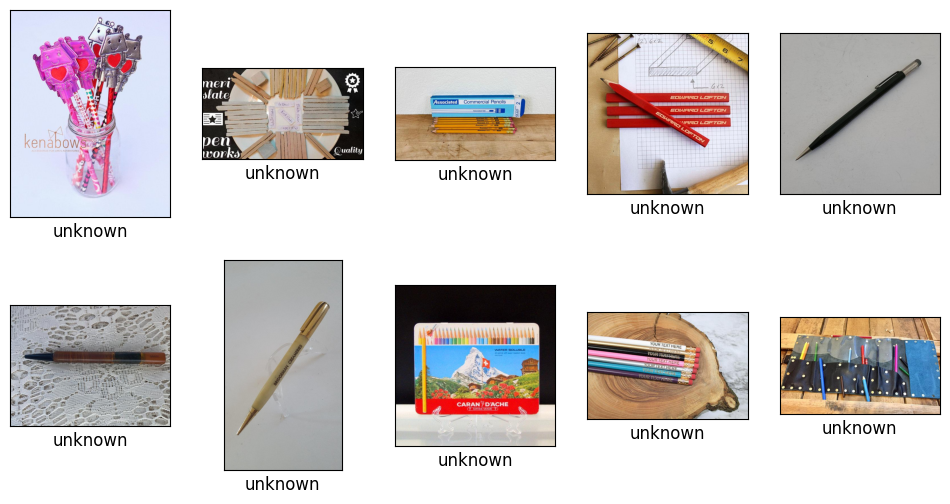

In [ ]:
show_images(df_test, 10)

In [51]:
df_test.head()

product_id                                              title  \
0  1229042350  The Verve Cling 1997 Vintage Urban Hymns Band ...   
1   928264000  Me OR My Son Sticker / Great for journaling, s...   
2  1102419460  Breast Cancer Awareness Ribbon Flower Sticker ...   
3  1082414690  Beetlejuice Vinyl Sticker | Horror Movie Stickers   
4   593640880                             Feminist Vinyl Sticker   

                                         description  \
0  The Verve - Urban Hymns Window Cling Poster (r...   
1  *Includes 2 small stickers*\nI include at leas...   
2  This is a project I was really excited to be w...   
3  Beetlejuice Artwork on Vinyl Sticker \n\nAvail...   
4  FEMINIST sticker. \n\nPerfect for your car or ...   

                                                tags      type room  \
0  verve,urban hymns,alternative,brit pop,richard...  physical        
1  sassy,handmade,laptop,cute,vine reference,tikt...  physical        
2  Small Sticker,gift,boho,Decals,Cancer Ribbon,C...  physical        
3  vinyl stickers movie,Beetlejuice,movie sticker...  physical        
4  women's rights,Butch and Sissy,Queer Gift,LGBT...  physical        

  craft_type recipient material  occasion    holiday art_subject    style  \
0                                                                 hipster   
1                                                                           
2                                                                           
3                                birthday  halloween                        
4                                                                           

  shape pattern                                      image/encoded  \
0                b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
1                b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
2                b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
3                b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
4                b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   

   image/width  image/height  
0          570           577  
1          570           760  
2          570           570  
3          570           478  
4          570           570

In [52]:
# preprocess title
df_test['cleaned_title'] = df_test['title'].apply(preprocess_text)

In [54]:
test_text = df_test['cleaned_title']

In [55]:
#tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(test_text)
test_sequences = tokenizer.texts_to_sequences(test_text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 77927 unique tokens.


In [56]:
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [57]:
# Make predictions
predictions = best_model.predict(test_data)

798/798 [==============================] - 8s 10ms/step


In [62]:
predictions

[array([[3.5249542e-03, 1.5183163e-02, 3.6302986e-04, ..., 1.1977016e-03,
         5.4756235e-03, 1.5261411e-02],
        [1.8748331e-03, 3.3068496e-03, 1.7164596e-03, ..., 1.3658440e-03,
         4.0475219e-03, 5.7465971e-02],
        [3.0483920e-02, 1.9288007e-02, 5.8092043e-02, ..., 1.0052203e-01,
         2.3592534e-02, 2.3910782e-01],
        ...,
        [2.2937836e-02, 2.7868832e-03, 4.6058673e-01, ..., 7.3211157e-04,
         7.3236205e-02, 6.5558217e-02],
        [8.3558683e-05, 3.0907989e-03, 9.5451251e-06, ..., 1.6176851e-05,
         1.4766083e-03, 1.7369106e-05],
        [3.0868903e-02, 4.0309392e-03, 2.6969386e-03, ..., 9.1877190e-04,
         2.4561561e-03, 2.5682464e-02]], dtype=float32),
 array([[2.5275862e-04, 1.2144539e-02, 2.4192112e-04, ..., 4.3106475e-06,
         1.4937704e-06, 7.1435403e-05],
        [8.9781609e-04, 4.9630203e-03, 2.9990601e-05, ..., 2.5460511e-05,
         1.0028841e-07, 6.4848183e-07],
        [1.0028113e-04, 3.1535168e-05, 1.9129207e-06, ...,

In [63]:
# Convert probabilities to class indices
predicted_classes = [np.argmax(pred, axis=1) for pred in predictions]


In [65]:
from sklearn.preprocessing import LabelEncoder

# Example loading of LabelEncoders if not already in memory
# You would typically load these from disk using joblib or pickle
# import joblib
# label_encoders = [joblib.load(f"label_encoder_{i}.pkl") for i in range(4)]
encoders = [le_top_category, le_bottom_category,le_primary_color, le_secondary_color]
# Decode each set of predicted labels to original classes
decoded_predictions = [encoders[i].inverse_transform(predicted_classes[i]) for i in range(4)]


In [66]:
import pandas as pd
result_df = pd.DataFrame({
    'ID': df_test['product_id'],
    'Predicted_Top': decoded_predictions[0],
    'Predicted_Bottom': decoded_predictions[1],
    'Predicted_Pcolor': decoded_predictions[2],
    'Predicted_Scolor': decoded_predictions[3]
})


In [67]:
result_df.head(2)

ID  Predicted_Top  Predicted_Bottom  Predicted_Pcolor  \
0  1229042350              6               483                 2   
1   928264000              5               516                 1   

   Predicted_Scolor  
0                 2  
1                17

In [68]:
# Saving predictions
student_id = "23260391"
result_df.to_parquet(f'predictions_{student_id}.parquet')


In [69]:
# Load Parquet file
verified_df = pd.read_parquet('predictions_23260391.parquet')
print(verified_df.head())


           ID  Predicted_Top  Predicted_Bottom  Predicted_Pcolor  \
0  1229042350              6               483                 2   
1   928264000              5               516                 1   
2  1102419460             14               483                11   
3  1082414690              0                 9                17   
4   593640880              0                30                 2   

   Predicted_Scolor  
0                 2  
1                17  
2                17  
3                17  
4                17  


#Word2Vec


In [ ]:
!pip install gensim


In [ ]:
import gensim
from gensim.models import Word2vec, KeyedVectors
from gensim.models.word2vec import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import string

In [ ]:
gensim.__version__

'4.3.2'

In [ ]:
np.random.seed(42)

In [ ]:
import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
wv = api.load('word2vec-google-news-300')
wv.save('/content/drive/MyDrive/2024/vectors.kv')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
print(wv['accessories'])
print(len(wv['accessories']))

[-2.89306641e-02  1.07910156e-01 -1.07421875e-01  1.86523438e-01
 -2.33459473e-03 -1.97753906e-02  1.00097656e-01 -1.20117188e-01
 -1.78710938e-01  2.05078125e-01 -1.04492188e-01 -1.98974609e-02
  1.68457031e-02  8.54492188e-02  9.27734375e-02 -2.71484375e-01
  1.19628906e-01  1.87500000e-01 -1.64794922e-02 -1.00585938e-01
  2.87109375e-01 -1.47460938e-01 -1.69921875e-01 -5.54199219e-02
 -1.04003906e-01  2.38281250e-01 -2.15820312e-01  2.15820312e-01
  1.16699219e-01 -2.79296875e-01 -1.39648438e-01  2.13623047e-02
  5.88378906e-02  3.41796875e-01 -5.24902344e-02 -2.08984375e-01
 -2.28271484e-02 -2.08007812e-01 -1.40625000e-01 -1.85546875e-01
 -1.07910156e-01  2.75390625e-01 -8.83789062e-02  4.36401367e-03
 -2.48046875e-01 -3.28125000e-01 -5.98144531e-02  5.10253906e-02
  9.13085938e-02  4.07714844e-02  1.14257812e-01  9.47265625e-02
  1.55273438e-01  9.03320312e-02  1.09375000e-01 -1.58203125e-01
 -8.93554688e-02  7.37304688e-02 -5.78613281e-02  1.78710938e-01
 -2.36328125e-01 -8.39843

In [ ]:
print(wv['candy'])
print(len(wv['candy']))

[-5.00488281e-02 -2.32421875e-01 -3.08837891e-02  4.72656250e-01
 -1.85546875e-01  7.61718750e-02  1.17187500e-01 -1.73339844e-02
 -2.63671875e-01  1.62109375e-01  9.27734375e-02 -1.84570312e-01
  1.05590820e-02  1.97265625e-01 -1.15234375e-01 -5.17578125e-02
 -1.70898438e-01  7.08007812e-02 -3.22265625e-01 -3.28125000e-01
  2.17773438e-01 -9.52148438e-02  1.31835938e-01  2.61718750e-01
  9.22851562e-02  1.50390625e-01 -2.96630859e-02  1.90429688e-01
  4.10156250e-02  4.19921875e-02 -1.76757812e-01 -1.74804688e-01
  5.05371094e-02  1.87500000e-01 -2.40234375e-01  3.80859375e-02
  1.73828125e-01 -1.46484375e-01  5.64575195e-03  3.24218750e-01
 -1.47460938e-01 -1.26953125e-01  1.64062500e-01  5.02929688e-02
 -2.03125000e-01  8.98437500e-02 -2.22656250e-01  1.43554688e-01
  7.17773438e-02  9.47265625e-02 -1.25976562e-01  1.83593750e-01
 -5.68847656e-02 -1.33789062e-01 -1.09375000e-01  6.78710938e-02
  2.63671875e-01 -2.28515625e-01 -2.98828125e-01 -1.95312500e-01
  3.88183594e-02  7.61718

In [ ]:
print(wv.most_similar(positive=['wrapper', 'candy'], topn=5))


[('wrappers', 0.6748063564300537), ('candies', 0.6575084328651428), ('Starburst_candy', 0.6258964538574219), ('cellophane_wrappers', 0.6240320801734924), ('Ziploc_baggies', 0.6179333329200745)]


In [ ]:
print(wv.most_similar(positive=['printable'], topn=5))

NameError: name 'wv' is not defined

In [ ]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load('/content/drive/MyDrive/2024/vectors.kv')

In [ ]:
df_train['cleaned_top_category_text'] = df_train['top_category_text'].apply(preprocess_text)
df_train['cleaned_bottom_category_text'] = df_train['bottom_category_text'].apply(preprocess_text)

In [ ]:
df_train['cleaned_description'] = df_train['description'].apply(preprocess_text)

In [ ]:
#Average word vectors to form a sentence vector of the same dimensions
def sentence_vector(sentence):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    # print(wv_res)
    ctr = 1
    for w in sentence:
        if w in wv:
            ctr += 1
            wv_res += wv[w]
    wv_res = wv_res/ctr
    return wv_res


In [ ]:
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize


# Tokenize the text in each row
df_train['tokenized_title'] = df_train['cleaned_title'].apply(word_tokenize)
df_train['title_vectors'] = df_train['tokenized_title'].apply(sentence_vector)

In [ ]:
df_train.head(3)

product_id                                              title  \
0  1548741755  Unicorn Macrame Wall Hanging, Unicorn nursery ...   
1   853508528  Fiber Art Macrame Wall Hanging with Browns, Cr...   
2   988875629  Macrame Plant Pod Dip Dye Blue Recycled Cotton...   

                                         description  \
0  A small Unicorn-colored theme macrame wall han...   
1  Aloha! \n\nLovely Handmade wall decor with neu...   
2  Handmade and hand dyed macrame pod.\nPerfect f...   

                                                tags      type     room  \
0  Unicorn Decor,Macramé Art,Nursery Wall Decor,G...  physical            
1  dreamcatcher,living room decor,boho wall hangi...  physical  bedroom   
2  plant pod,macrame hanger,macrame storage,macra...  physical            

  craft_type recipient material occasion  ... secondary_color_text  \
0                                         ...                 pink   
1                                         ...                beige   
2                                         ...                 blue   

                                       image/encoded image/width image/height  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...         425          564   
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...         570         1023   
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...         570          713   

                                       cleaned_title  \
0  unicorn macrame wall hanging unicorn nursery d...   
1  fiber art macrame wall hanging brown cream gol...   
2  macrame plant pod dip dye blue recycled cotton...   

                                 cleaned_description title_length  \
0  small unicorn colored theme macrame wall hangi...          132   
1  aloha \n\nlovely handmade wall decor neutral c...          109   
2  handmade hand dyed macrame pod \nperfect plant...           55   

   description_length                                    tokenized_title  \
0                 402  [unicorn, macrame, wall, hanging, unicorn, nur...   
1                 396  [fiber, art, macrame, wall, hanging, brown, cr...   
2                 330  [macrame, plant, pod, dip, dye, blue, recycled...   

                                       title_vectors  
0  [0.0262451171875, 0.030322804170496324, -0.008...  
1  [-0.05579566955566406, 0.05806732177734375, 0....  
2  [-0.031396484375, 0.041162109375, -0.002319335...  

[3 rows x 32 columns]

## Sentence Vectors as Input feature

# BERT

In [ ]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from transformers import BertTokenizer
#from datasets import load_dataset

In [ ]:
!pip install pytorch_pretrained_bert pytorch-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [ ]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#BERT needs to understand 2 things:
#1) The start and end of each sentiment
# so we declare a special token CLS which tells BERT that its a classification task
sentences = df['cleaned_title']
sentence = ["[CLS] "+i+" [SEP]" for i in sentences]

In [ ]:
sentence[0]

'[CLS] 70 swimwear men swim trunk vintage swimwear swim short beachwear retro summer clothes holiday collectible size riga [SEP]'

In [ ]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Restricting the max size of Tokens to 512(BERT doest accept any more than this)
tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:510] , sentence))
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 1275191.45B/s]


Tokenize the first sentence:
['[CLS]', '70', 'swim', '##wear', 'men', 'swim', 'trunk', 'vintage', 'swim', '##wear', 'swim', 'short', 'beach', '##wear', 'retro', 'summer', 'clothes', 'holiday', 'collect', '##ible', 'size', 'riga', '[SEP]']


In [ ]:
labels = list(df['top_category_id'])#storing the labels

In [ ]:
# Set the maximum sequence length.
MAX_LEN = 128

# Pad our input tokens so that everything has a uniform length
input_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, tokenized_texts)),
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [ ]:
# Split Data
# 10% for validation
df_training, df_validation = train_test_split(
    df, test_size=0.1, stratify=df["bottom_category_text"], random_state=42
)
# 5% for test
df_training, df_test = train_test_split(
    df_training, test_size=0.05, stratify=df_training["bottom_category_text"], random_state=42
)

print(f"Total training examples: {len(df_training)}")
print(f"Total validation examples: {len(df_validation)}")
print(f"Total test examples: {len(df_test)}")

Total training examples: 195635
Total validation examples: 22882
Total test examples: 10297


In [ ]:
# Select a batch size for training.
batch_size = 16

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=42, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
#Loading pre trained BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=15)
if torch.cuda.is_available():
    print(model.cuda())
else:
    print(model)

100%|██████████| 407873900/407873900 [00:11<00:00, 35166942.69B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
token = tokenizer.encode_plus(
    df_train['cleaned_title'].iloc[0],
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)


In [ ]:

token.input_ids

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101,  8362, 23941, 23639,  4515,  1162,  2095,  5205,  8362,
        23941, 17840, 12824,  2027,  1395,  2095,  1893,  8362, 23941,
        12824,  1873,  1395, 17840,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [ ]:

X_input_ids = np.zeros((len(df_train), 256))
X_attn_masks = np.zeros((len(df_train), 256))

In [ ]:
from tqdm.auto import tqdm

def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['cleaned_title'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks



In [ ]:
X_input_ids, X_attn_masks = generate_training_data(df_train, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [ ]:
top_category_label = np.zeros((len(df_train),len(set(df_train['top_category_text'])) ))
top_category_label.shape

(229624, 15)

In [ ]:
top_category_label[np.arange(len(df_train)), df_train['top_category_id'].values] = 1 # one-hot encoded target tensor
top_category_label

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, top_category_label))
dataset.take(1) # one sample data

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(15,), dtype=tf.float64, name=None))>

In [ ]:
def DatasetMapFunction(input_ids, attn_masks, top_category_label):
  return {
      'input_ids': input_ids,
      'attention_mask': attn_masks
    }, top_category_label

In [ ]:
dataset = dataset.map(DatasetMapFunction) # converting to required format for tensorflow dataset
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(15,), dtype=tf.float64, name=None))>

In [ ]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 15), dtype=tf.float64, name=None))>

In [ ]:
p = 0.8
train_size = int((len(df_train)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.


In [ ]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

## Model

In [ ]:
from transformers import TFBertModel

In [ ]:
model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')


In [ ]:
# Get the outputs from BERT
bert_outputs = model.bert(input_ids, attn_masks)[0]

# BERT's pooled_output is used for tasks like classification
# It's already been through a dense layer with tanh activation
pooled_output = bert_outputs['pooler_output']

# Add your additional layers
intermediate_layer = layers.Dense(512, activation='relu', name='intermediate_layer')(pooled_output)
output_layer = layers.Dense(15, activation='softmax', name='output_layer')(intermediate_layer)

# Build the model
model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)

# Print the summary to verify the model architecture
model.summary()

TypeError: Exception encountered when calling layer 'embeddings' (type TFBertEmbeddings).

Could not build a TypeSpec for name: "tf.debugging.assert_less_2/assert_less/Assert/Assert"
op: "Assert"
input: "tf.debugging.assert_less_2/assert_less/All"
input: "tf.debugging.assert_less_2/assert_less/Assert/Assert/data_0"
input: "tf.debugging.assert_less_2/assert_less/Assert/Assert/data_1"
input: "tf.debugging.assert_less_2/assert_less/Assert/Assert/data_2"
input: "Placeholder"
input: "tf.debugging.assert_less_2/assert_less/Assert/Assert/data_4"
input: "tf.debugging.assert_less_2/assert_less/y"
attr {
  key: "T"
  value {
    list {
      type: DT_STRING
      type: DT_STRING
      type: DT_STRING
      type: DT_INT32
      type: DT_STRING
      type: DT_INT32
    }
  }
}
attr {
  key: "summarize"
  value {
    i: 3
  }
}
 of unsupported type <class 'tensorflow.python.framework.ops.Operation'>.

Call arguments received by layer 'embeddings' (type TFBertEmbeddings):
  • input_ids=<KerasTensor: shape=(None, 256) dtype=int32 (created by layer 'input_ids')>
  • position_ids=None
  • token_type_ids=<KerasTensor: shape=(None, 256) dtype=int32 (created by layer 'tf.fill_2')>
  • inputs_embeds=None
  • past_key_values_length=0
  • training=False

In [ ]:

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(15, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
sentiment_model.summary()


TypeError: Exception encountered when calling layer 'embeddings' (type TFBertEmbeddings).

Could not build a TypeSpec for name: "tf.debugging.assert_less_7/assert_less/Assert/Assert"
op: "Assert"
input: "tf.debugging.assert_less_7/assert_less/All"
input: "tf.debugging.assert_less_7/assert_less/Assert/Assert/data_0"
input: "tf.debugging.assert_less_7/assert_less/Assert/Assert/data_1"
input: "tf.debugging.assert_less_7/assert_less/Assert/Assert/data_2"
input: "Placeholder"
input: "tf.debugging.assert_less_7/assert_less/Assert/Assert/data_4"
input: "tf.debugging.assert_less_7/assert_less/y"
attr {
  key: "T"
  value {
    list {
      type: DT_STRING
      type: DT_STRING
      type: DT_STRING
      type: DT_INT32
      type: DT_STRING
      type: DT_INT32
    }
  }
}
attr {
  key: "summarize"
  value {
    i: 3
  }
}
 of unsupported type <class 'tensorflow.python.framework.ops.Operation'>.

Call arguments received by layer 'embeddings' (type TFBertEmbeddings):
  • input_ids=<KerasTensor: shape=(None, 256) dtype=int32 (created by layer 'input_ids')>
  • position_ids=None
  • token_type_ids=<KerasTensor: shape=(None, 256) dtype=int32 (created by layer 'tf.fill_7')>
  • inputs_embeds=None
  • past_key_values_length=0
  • training=False

In [ ]:
output = model(inputs)
output

In [ ]:

train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [ ]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from sklearn.metrics import f1_score

# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = TFAutoModel.from_pretrained(model_name)

# Assume you've already preprocessed your data and have:
# train_titles, train_top_category, train_bottom_category,
# train_primary_color, train_secondary_color (encoded labels)
# val_titles, val_top_category, val_bottom_category,
# val_primary_color, val_secondary_color
# test_titles, test_top_category, test_bottom_category,
# test_primary_color, test_secondary_color

# Tokenize input titles
train_input_ids = tokenizer(train_titles, padding=True, truncation=True, return_tensors="tf")["input_ids"]
val_input_ids = tokenizer(val_titles, padding=True, truncation=True, return_tensors="tf")["input_ids"]
test_input_ids = tokenizer(test_titles, padding=True, truncation=True, return_tensors="tf")["input_ids"]

# Build the model
input_layer = tf.keras.layers.Input(shape=(None,), dtype=tf.int32)
bert_output = bert_model(input_layer)[0]
output_layer = tf.keras.layers.Dense(4, activation="sigmoid")(bert_output)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(train_input_ids, [train_top_category, train_bottom_category,
                            train_primary_color, train_secondary_color],
          epochs=5, validation_data=(val_input_ids, [val_top_category, val_bottom_category,
                                                      val_primary_color, val_secondary_color]))

# Evaluate the model
test_predictions = model.predict(test_input_ids)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Compute F1 score for each feature
f1_top_category = f1_score(test_top_category, test_predictions_binary[:, 0], average="weighted")
f1_bottom_category = f1_score(test_bottom_category, test_predictions_binary[:, 1], average="weighted")
f1_primary_color = f1_score(test_primary_color, test_predictions_binary[:, 2], average="weighted")
f1_secondary_color = f1_score(test_secondary_color, test_predictions_binary[:, 3], average="weighted")

print(f"Test F1 (Top Category): {f1_top_category:.4f}")
print(f"Test F1 (Bottom Category): {f1_bottom_category:.4f}")
print(f"Test F1 (Primary Color): {f1_primary_color:.4f}")
print(f"Test F1 (Secondary Color): {f1_secondary_color:.4f}")


In [ ]:
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Sample DataFrame loading (replace with your actual DataFrame)
# df = pd.DataFrame({'bottom_category_text': [...]})

# Preprocess the 'bottom_category_text' column
df['cleaned_bottom_category_text'] = df['bottom_category_text'].str.lower().str.replace('_', ' ')

# Tokenize the cleaned text
df['tokenized_text'] = df['cleaned_bottom_category_text'].apply(word_tokenize)

# List of tokenized documents
tokenized_docs = df['tokenized_text'].tolist()

# Training the Word2Vec model
model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=1, workers=4)

# Now `model` can be used for obtaining vectors for the words in your 'bottom_category_text'


In [ ]:
df['cleaned_top_category'] = df['top_category_text'].apply(preprocess_text)
df['cleaned_bottom_category'] = df['bottom_category_text'].apply(preprocess_text)

<ipython-input-35-252d11db153a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_top_category'] = df['top_category_text'].apply(preprocess_text)
<ipython-input-35-252d11db153a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_bottom_category'] = df['bottom_category_text'].apply(preprocess_text)


In [ ]:
# Combine title and description for vectorization
df['embeddings_text'] = df['cleaned_title'] + ' ' + df['cleaned_top_category'] + df['cleaned_bottom_category']

<ipython-input-38-e4f8e2573e29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['embeddings_text'] = df['cleaned_title'] + ' ' + df['cleaned_top_category'] + df['cleaned_bottom_category']


In [ ]:
df['cleaned_top_category'].value_counts()

cleaned_top_category
home living              54402
craft supply tool        33291
clothing                 29941
toy game                 13777
accessory                12372
paper party supply       12162
bath beauty              11302
wedding                  10100
shoe                      8888
art collectible           8710
jewelry                   7811
electronics accessory     7465
bag purse                 6603
book movie music          6255
pet supply                5735
Name: count, dtype: int64

In [ ]:
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Tokenize the text in each row
#df['embeddings_text'] = df['embeddings_text'].apply(word_tokenize)

# Convert the DataFrame column into a list of lists (required by Word2Vec)
sentences = df['embeddings_text'].tolist()

# Train the Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

# If you need to train further, you can continue training with the trained model like this
# w2v_model.train(more_sentences, total_examples=model.corpus_count, epochs=model.epochs)

# Save the model to use it later
w2v_model.save("etsy_word2vec.model")

# To use the model, load it and use as follows
# w2v_model = Word2Vec.load("etsy_word2vec.model")

# Access vector for one word
print(w2v_model.wv['accessory'])  # Replace 'product' with a word from your corpus

# Most similar words
print(w2v_model.wv.most_similar('birthday'))  # Replace 'product' with a word from your corpus


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[-2.7816496   1.627128    1.636034    0.24222957 -2.6989985   0.23141213
  1.2670851  -1.202635    0.4233842   0.8007529   0.24780503  0.6123672
 -2.7229085   2.1302898  -3.489608   -3.4522572  -1.9087704   2.5895648
 -0.48548287  0.96310407 -0.8507666  -0.11452614  0.5041335  -1.4716511
  0.12070554 -0.35612106  0.93163496  0.89366645  1.3102789  -1.0896853
  0.10461372  1.3665024   0.13607079  1.573847    3.6599329   0.6285368
  0.11499747 -1.3948977  -1.6026856  -0.24261495 -0.10895199 -0.81175405
 -1.139137    1.3348947   0.57241225  0.12743917 -0.3812761  -0.9441821
  4.2956634  -3.3121147  -2.4561033  -1.521649    0.8265727   0.83900493
  1.4347632  -1.4325068  -1.1878172   1.4271377  -0.21385147  1.0222152
  1.8506148  -0.9227501   1.353802   -0.8578179   1.0050089  -2.5928915
  2.5080068   0.40424323 -0.99874234  0.4845831  -0.74158716  0.04149402
 -0.24100448 -3.4794762  -0.6243722   2.4507043  -0.22317414 -1.535062
 -0.01888431  1.8386315   2.0124004   0.2582794   1.1311     

In [ ]:
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Tokenize the text in each row
df_train['tokenized_text'] = df_train['cleaned_title'].apply(word_tokenize)

# Convert the DataFrame column into a list of lists (required by Word2Vec)
sentences = df_train['tokenized_text'].tolist()

# Train the Word2Vec model
w2v_model = Word2Vec(sentences= df_train['tokenized_text'], vector_size=100, window=5, min_count=5, workers=4)

# If you need to train further, you can continue training with the trained model like this
# w2v_model.train(more_sentences, total_examples=model.corpus_count, epochs=model.epochs)

# Save the model to use it later
w2v_model.save("etsy_word2vec.model")

# To use the model, load it and use as follows
# w2v_model = Word2Vec.load("etsy_word2vec.model")

# Access vector for one word
print(w2v_model.wv['printable'])  # Replace 'product' with a word from your corpus

# Most similar words
print(w2v_model.wv.most_similar('birthday'))  # Replace 'product' with a word from your corpus


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[-3.14578742e-01  8.89896870e-01 -8.52975845e-01  5.81050515e-01
 -8.29635799e-01 -1.43496466e+00  1.78612089e+00  1.54605579e+00
 -1.73322546e+00 -1.59101820e+00  2.73170233e+00  6.45644426e-01
  1.73117086e-01 -1.91457582e+00  4.16006148e-01  1.83337778e-01
  1.32146776e-01  5.21509290e-01 -1.09653093e-01  3.11855346e-01
 -2.29391789e+00  4.13219541e-01 -1.08152837e-01  6.46018624e-01
  3.21552575e-01 -3.15289080e-01 -3.37185860e-01 -1.11563241e+00
 -4.76647347e-01 -2.46106297e-01  1.57556045e+00  6.44437969e-02
  1.56154990e+00  1.99145544e+00 -1.59634662e+00  1.32596672e-01
  1.62433445e+00 -1.49001956e+00  7.17467427e-01 -1.13517177e+00
 -1.30341065e+00  8.24751854e-01  5.76936781e-01  1.67800629e+00
 -1.07215488e+00  1.34539354e+00  9.27128315e-01 -5.47545850e-01
 -1.10780549e+00  1.96610594e+00 -3.24751347e-01 -1.48383349e-01
 -3.16270590e-01  2.00580764e+00  1.04811333e-01  1.45522642e+00
  5.56681633e-01  6.63605481e-02 -4.08897519e-01 -1.46676946e+00
 -8.33399832e-01  2.52423

# BERT


In [ ]:
!pip install transformers

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def encode_texts(texts):
    return tokenizer.batch_encode_plus(
        texts,
        max_length=256,  # Choose a number that suits your use case
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

# Apply the tokenizer to the title column
encoded_texts = encode_texts(df_train['cleaned_title'].tolist())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
label_encoders = {}
for column in ['top_category_text', 'bottom_category_text', 'primary_color_text', 'secondary_color_text']:
    le = LabelEncoder()
    df_training[column] = le.fit_transform(df_training[column])
    label_encoders[column] = le

# Extract target variables
y_train = [df_training[output].values for output in label_encoders]


In [ ]:
input_ids = tf.keras.Input(shape=(512,), name='input_ids', dtype='int32')
attention_masks = tf.keras.Input(shape=(512,), name='attention_masks', dtype='int32')

bert = TFAutoModel.from_pretrained('bert-base-uncased')

bert_output = bert(input_ids, attention_mask=attention_masks)[0]

# Create a separate output layer for each target variable
output_layers = []
for output, le in label_encoders.items():
    num_labels = len(le.classes_)
    output_layer = tf.keras.layers.Dense(num_labels, activation='softmax', name=output)(bert_output)
    output_layers.append(output_layer)

model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output_layers)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
losses = {output: 'sparse_categorical_crossentropy' for output in label_encoders}
metrics = {output: 'accuracy' for output in label_encoders}

model.compile(optimizer=optimizer, loss=losses, metrics=metrics)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

TypeError: Exception encountered when calling layer 'embeddings' (type TFBertEmbeddings).

Could not build a TypeSpec for name: "tf.debugging.assert_less_1/assert_less/Assert/Assert"
op: "Assert"
input: "tf.debugging.assert_less_1/assert_less/All"
input: "tf.debugging.assert_less_1/assert_less/Assert/Assert/data_0"
input: "tf.debugging.assert_less_1/assert_less/Assert/Assert/data_1"
input: "tf.debugging.assert_less_1/assert_less/Assert/Assert/data_2"
input: "Placeholder"
input: "tf.debugging.assert_less_1/assert_less/Assert/Assert/data_4"
input: "tf.debugging.assert_less_1/assert_less/y"
attr {
  key: "T"
  value {
    list {
      type: DT_STRING
      type: DT_STRING
      type: DT_STRING
      type: DT_INT32
      type: DT_STRING
      type: DT_INT32
    }
  }
}
attr {
  key: "summarize"
  value {
    i: 3
  }
}
 of unsupported type <class 'tensorflow.python.framework.ops.Operation'>.

Call arguments received by layer 'embeddings' (type TFBertEmbeddings):
  • input_ids=<KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'input_ids')>
  • position_ids=None
  • token_type_ids=<KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'tf.fill_1')>
  • inputs_embeds=None
  • past_key_values_length=0
  • training=False

In [ ]:
batch_size = 32
epochs = 5

history = model.fit(
    {'input_ids': encoded_texts['input_ids'], 'attention_masks': encoded_texts['attention_mask']},
    y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs
)


In [ ]:
from sklearn.metrics import f1_score

# Assume X_val_encoded and y_val are prepared similarly to X_train_encoded and y_train
val_predictions = model.predict({'input_ids': X_val_encoded['input_ids'], 'attention_masks': X_val_encoded['attention_mask']})

# The model outputs a list of predictions for each output
# To calculate the F1 score for each class, we need to process these predictions
f1_scores = {}
for i, (output, le) in enumerate(label_encoders.items()):
    y_true = y_val[i]
    y_pred = tf.argmax(val_predictions[i], axis=1).numpy()
    f1_scores[output] = f1_score(y_true, y_pred, average='weighted')

print(f1_scores)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Sample data loading
# df_train = pd.read_csv('your_dataset.csv')

# Preprocessing steps as defined earlier

# Combine title and description for vectorization
df_train['combined_text'] = df_train['title'] + ' ' + df_train['description']

# Vectorize text data
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(df_train['combined_text'])

# Target variables
y = df_train[['top_category_text', 'bottom_category_text', 'primary_color_text', 'secondary_color_text']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.1, stratify=df_train['bottom_category_text'], random_state=42)

# Define multioutput wrapper function for training and evaluation
def train_and_evaluate(model, df_training, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    for i, target_name in enumerate(y_train.columns):
        print(f"Classification report for {target_name}:")
        print(classification_report(y_test.iloc[:, i], predictions[:, i], zero_division=0))

# Logistic Regression
print("Logistic Regression Results:")
lr_model = MultiOutputClassifier(LogisticRegression(max_iter=1000))
train_and_evaluate(lr_model, X_train, y_train, X_test, y_test)

# Support Vector Machine
print("Support Vector Machine Results:")
svm_model = MultiOutputClassifier(LinearSVC())
train_and_evaluate(svm_model, X_train, y_train, X_test, y_test)

# Random Forest
print("Random Forest Results:")
rf_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100))
train_and_evaluate(rf_model, X_train, y_train, X_test, y_test)


Logistic Regression Results:


### Training

As another example, let's train an image classification model to predict color based only on the image as input. We leveraged `MobileNet` as the base model with `imagenet` weights and freezing the layers.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Sample 5% training dataset for running the notebook in one machine
df_training_sample = df_training.groupby('primary_color_id').sample(frac=0.05)

In [ ]:
f"Number of rows: {len(df_training_sample):,}"

'Number of rows: 10,332'

In [ ]:
NUM_CHANNELS = 3
NUM_COLORS = 19

def parse_dataset(features):

    # Features
    image_encoded = features["image"]
    img_width = features["width"]
    img_height = features["height"]
    primary_color_id = features["primary_color_id"]

    # Image
    image = tf.reshape(
        tf.io.decode_jpeg(image_encoded),
        [img_height, img_width, NUM_CHANNELS],
    )
    image = tf.cast(image, tf.float32)

    # Label
    label = tf.cast(tf.one_hot(primary_color_id, NUM_COLORS), tf.int64)

    return (
        { "image": image, },
        label
    )

In [ ]:
def create_preprocessing_model(target_image_size, should_rescale):
    preprocessing_layers = []
    if should_rescale:
        preprocessing_layers.append(
            tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)
        )
    preprocessing_layers.append(
        tf.keras.layers.experimental.preprocessing.Resizing(
            target_image_size, target_image_size
        )
    )
    return tf.keras.Sequential(preprocessing_layers)

In [ ]:
def transform_image_data(example, preprocessing_model):
    image = tf.expand_dims(example["image"], 0)
    example["image"] = preprocessing_model(image)[0]
    return example

In [ ]:
def get_dataset_batch(
    dataframe,
    batch_size: int,
    mode: tf.estimator.ModeKeys,
) -> tf.data.Dataset:
    augment = shuffle = mode == tf.estimator.ModeKeys.TRAIN
    # Adding all values in memory will not work for the whole dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (
            {
                "image": tf.convert_to_tensor(dataframe["image/encoded"].values, dtype=tf.string),
                "height": tf.convert_to_tensor(dataframe["image/height"].values, dtype=tf.int32),
                "width": tf.convert_to_tensor(dataframe["image/width"].values, dtype=tf.int32),
                "primary_color_id": tf.convert_to_tensor(dataframe["primary_color_id"].values, dtype=tf.int32),
            }
        )
    )
    dataset = dataset.map(
        lambda x: parse_dataset(x),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    preprocessing_model = create_preprocessing_model(
        target_image_size=224,
        should_rescale=True,
    )
    dataset = dataset.map(
        lambda x, y: (transform_image_data(x, preprocessing_model), y),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
BATCH_SIZE = 16

In [ ]:
train_dataset = get_dataset_batch(
    dataframe=df_training_sample,
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN,
)

2024-02-12 14:28:02.024496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 14:28:02.030905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 14:28:02.138516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
val_dataset = get_dataset_batch(
    dataframe=df_validation,
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.EVAL,
)

In [ ]:
gpus = tf.config.list_physical_devices("GPU")
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [ ]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [ ]:
with strategy.scope():

    input_shape = (224, 224, 3)
    inputs = tf.keras.layers.Input(shape=input_shape, dtype=tf.float32, name="image")
    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_tensor=inputs)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(NUM_COLORS, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['image[0][0]']               
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_2[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                    

In [ ]:
epochs = 10

hist = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1)

Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 142 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 142 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-02-12 14:28:55.836993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-02-12 14:28:55.960355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-02-12 14:29:02.665256: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef3fac9aa80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-12 14:29:02.665355: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-02-12 14:29:02.665369: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-02-12 14:29:02.694220: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-12 14:29:02.897323: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!

645/645 [==============================] - 128s 102ms/step - loss: 2.1629 - accuracy: 0.6357 - val_loss: 9088.5488 - val_accuracy: 0.0909
Epoch 2/10
645/645 [==============================] - 62s 96ms/step - loss: 5.8938 - accuracy: 0.6586 - val_loss: 2.7948 - val_accuracy: 0.1205
Epoch 3/10
645/645 [==============================] - 62s 96ms/step - loss: 1.3813 - accuracy: 0.6915 - val_loss: 1079.1200 - val_accuracy: 0.1212
Epoch 4/10
645/645 [==============================] - 62s 97ms/step - loss: 1.6888 - accuracy: 0.6446 - val_loss: 6095.3735 - val_accuracy: 0.1212
Epoch 5/10
645/645 [==============================] - 63s 97ms/step - loss: 2.6767 - accuracy: 0.6808 - val_loss: 3.1608 - val_accuracy: 0.0500
Epoch 6/10
645/645 [==============================] - 62s 96ms/step - loss: 1.3834 - accuracy: 0.6478 - val_loss: 3.3098 - val_accuracy: 0.0718
Epoch 7/10
645/645 [==============================] - 62s 96ms/step - loss: 1.1660 - accuracy: 0.6985 - val_loss: 254.4213 - val_accurac

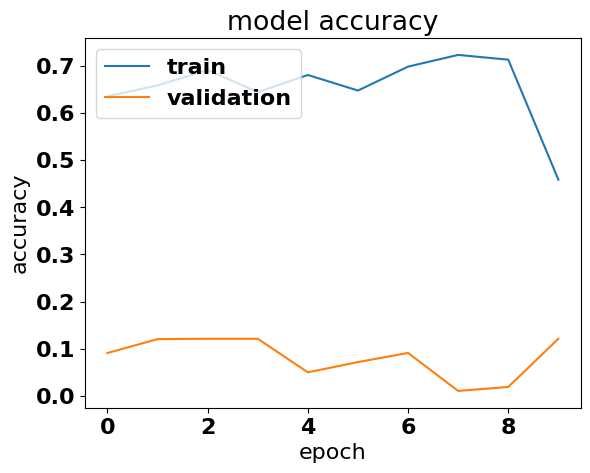

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [ ]:
model.evaluate(val_dataset, batch_size=BATCH_SIZE, verbose=1)

1435/1435 [==============================] - 31s 22ms/step - loss: 138.4445 - accuracy: 0.1212


[138.44451904296875, 0.12116724997758865]

In [ ]:
predictions = model.predict(val_dataset, batch_size=BATCH_SIZE, verbose=1)

1435/1435 [==============================] - 33s 21ms/step


In [ ]:
predictions

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

**Note** again that is just another baseline that only uses the `image` as the input and generates predictions after freezing all the layers for that base model.

Go wild and try different architectures and approaches, use several modalities, apply augmentations on the preprocessing layers, predict several targets at the same time, etc!

## Submission

Prepare a submission for the test data. Here I am using some dummy values, all zeros, as the ids for top categories, bottom categories, primary colors and secondary colors. Feed-forward the test data through your model, get the predictions per product and output them onto a file to be checked against the true values.

Happy Hacking!

In [ ]:
df_predictions = df_test.copy()

In [ ]:
# dummy values
df_predictions["top_category_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["bottom_category_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["primary_color_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["secondary_color_id"] = np.zeros(len(df_test), dtype=int)

In [ ]:
student_id = "12345689"
df_predictions[
    ["product_id", "top_category_id", "bottom_category_id", "primary_color_id", "secondary_color_id"]
].to_parquet(f"predictions_{student_id}.parquet")

# References
1. Scikit Learn documentation - https://scikit-learn.org/stable/modules/multiclass.html#
2. Practical Natural Language Processing by Sowmya Vajjala, Bodhisattwa Majumder, Anuj Gupta, Harshit Surana https://www.practicalnlp.ai/
3.